Проект: **FindCorr - торговый алгоритм, сервис для инвесторов и трейдеров**

Команда: **3БС!**

Члены команды: Тихон Павлов, Абдулгалимов Антон




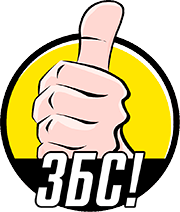

**О нашем торговом алгоритме**

Многие трейдеры слышали, что существуют некие, рыночно-нейтральные стратегии. Самый распространенный вид таких стратегий — Парный трейдинг.
Парный трейдинг- это когда мы торгуем 2-мя инструментами одновременно, причем один финансовый инструмент мы покупаем, а второй продаем.


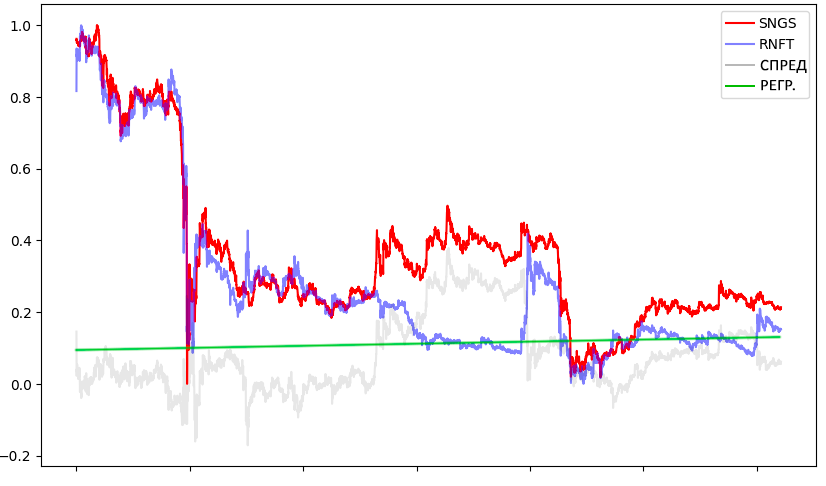


На картинке акции Роснефти и Сургутнефтегаза. Обе данные бумаги из нефтегазового сектора. Как видите, динамика акций очень похожа, бумаги имеют высокую корреляцию.

Теперь давайте построим спред между данными бумагами. Из цены акций Сургутнефтегаза вычтем цену акций Роснефти и получим серую линию на графике.

Прямая линия, которую Вы видите, строится при помощи линейной регрессии, по сути это вектор от которого отклоняется наш спрэд.

Мы получили динамику разницы одного актива по отношению к другому, отлично!

Сигналы на вход будут в тот момент когда наш спред экстремально отклоняется от средней линии.

Чаще всего данную стратегию применяют к торговле фьючерсами, но есть и другие варианты. Мы будем торговать только акциями, без маржинальной торговли. В качестве сигнала открытия мы можем использовать отклонение спрэда от средней линии на заданную величину, а в качестве сигнала закрытия – возврат спрэда к средней линии.

Это красивая, понятная стратегия доступная не только HFT-компаниях и алгоритмическим фондам, но и простым смертным.


**О нашем сервисе FindCorr.ru**


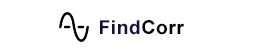

Помимо торговой стратегии мы создали сервис FindCorr.ru, который будет помогать находить корреляцию между инструментами. Наш сервис будет помогать подобрать инструменты, с сильной корреляцией. FindCorr.ru станет отличным подспорьем для трейдеров, практикующих парный трейдинг, а так же для инвесторов, которые хотят собрать диверсифцированный портфель из слабокоррелирующих инструментов.

**О нашей работе**

Мы специально оформили нашу работу таким образом, чтобы она могла стать классным кейсом для будущих пользователей AlgoPack. Весь код максимально читаем и снабжен комментариями, работа запускается в среде GoogleColab.

# Загрузка библиотек

Начнем с установки необходимых нам библиотек. Так же подключим google-диск, чтобы иметь возможность осуществлять промежуточное сохранение результатов.

In [ ]:
!pip install moexalgo
!pip install psycopg2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00


In [ ]:
from datetime import datetime, date, timedelta
from moexalgo import Market, Ticker
from sqlalchemy import create_engine, text as sql_text
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

import sys
import time
import math
import itertools
import requests
import pandas as pd
import numpy as np
import psycopg2 as pg
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install tinkoff-investments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.7/179.7 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.1 which is incompatible.


In [ ]:
from tinkoff.invest import SecurityTradingStatus
from tinkoff.invest.services import InstrumentsService

import os
import uuid
from datetime import timedelta
from decimal import Decimal

from tinkoff.invest import (
    Client,
    OrderDirection,
    OrderExecutionReportStatus,
    OrderType,
    PostOrderResponse,
    StopOrderDirection,
    StopOrderExpirationType,
    StopOrderType,
)
from tinkoff.invest.constants import INVEST_GRPC_API, INVEST_GRPC_API_SANDBOX
from tinkoff.invest.services import Services
from tinkoff.invest.utils import quotation_to_decimal, decimal_to_quotation, money_to_decimal, now

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Доступ к БД
DB_ACCESS = 'postgresql://***:***@***:***/findcorr_project'
DB_USER = '***'
DB_PASS = '***'

# Боевой токен для работы с брокером
TOKEN = '***'

# Downloader: получение/запись данных в БД для всех акций

Прежде всего, чтобы не обращаться постоянно к серверу МосБиржи, давайте "заберем" себе данные по интересующим нас тикерам. Полученные таким образом данные мы будем использовать не только в работе нашей торговой стратегии, но и при работе нашего сервиса поиска корреляций findcorr.ru.

Мы будем работать с 200 тикерами. Это самые популярные (можно сказать самые ликвидные) компании, по которым проводятся торги. Нам не очень интересны экзотические малоликвидные инструменты, потому что на их основе невозможно построить торговую стратегию - у них пустые или слишком разряженные стаканы.

Оценку "популярности" бумаги можно осуществить при помощи метода Tradestats, из AlgoPack Мосбиржи. Чем больше данных по инструменту - тем он ликвиднее и "популярнее".

In [ ]:
# Объявляем все тикеры, с которыми собрались работать
MYSTOCKS = [
    'SNGS','ROLO','RTKM','KMAZ','RTKMP','RUAL','SBER','SBERP','SFIN',
    'SGZH','IRAO','SIBN','HYDR','HNFG','MTSS','GLTR','SNGSP','GAZP','ROSN',
    'RNFT','FLOT','RENI','MOEX','NLMK','MGNT','NMTP','MDMG','MAGN','NVTK',
    'OGKB','LSRG','OZON','PHOR','LKOH','PIKK','PLZL','POLY','POSI','RASP',
    'SOFL','GMKN','FIXP','TRMK','CBOM','FIVE','MTLR','BSPB','UNAC','BELU',
    'BANEP','BANE','VKCO','ASTR','VTBR','AQUA','APTK','WUSH','ALRS','YNDX',
    'AGRO','AFLT','AFKS','CHMF','MVID','TCSG','TATNP','FESH','FEES','TATN',
    'MTLRP','EUTR','ETLN','ENPG','TGKA','SMLT','LSNGP','CARM','UPRO','IRKT',
    'ABRD','LIFE','ELFV','CIAN','GECO','TRNFP','HHRU','MSRS','NKHP','SPBE',
    'SVAV','MRKC','MRKP','QIWI','LENT','OKEY','MRKZ','NKNCP','GEMC','GTRK',
    'MRKV','MSNG','GCHE','SVET','DSKY','NSVZ','TTLK','ABIO','CHGZ','PRFN',
    'KLSB','CNTLP','KZOSP','LSNG','AVAN','RBCM','YAKG','TGKN','NKNC','EELT',
    'KAZT','LNZLP','MSTT','RUSI','ARSA','MGTSP','KZOS','MRKY','VSMO','UGLD',
    'MRKS','CNTL','MRKU','VRSB','AMEZ','DVEC','BLNG','PMSB','RKKE','TGKB',
    'RTSBP','KROT','KRKNP','KUZB','UNKL','VRSBP','TGKBP','PMSBP','RGSS',
    'KUBE','LNZL','KAZTP','KBSB','AKRN','TNSE','RTSB','BSPBP','ROSB','VLHZ',
    'INGR','MRKK','MAGE','MGTS','CHMK','ZVEZ','SLEN','NKSH','UTAR','DIOD',
    'BRZL','YRSBP','HIMCP','LVHK','KGKCP','SARE','BISVP','MISBP','TUZA',
    'NFAZ','DZRDP','USBN','HMSG','MISB','GEMA','STSBP','MRSB','NAUK',
    'IGSTP','KMEZ','KRSB','SAGO','NNSBP','TASB','MAGEP','ZILL','ROST',
    'YKEN','KCHE','RZSB','SAREP','STSB'
    ]

In [ ]:
# Функция получения всех свечных данных для тикера
def all_candles_for_ticker(ticker_code, num):

    # Объявляем абсурдно раннюю дату и сегодняшнюю дату
    absurd_start_date = '2000-01-01'
    end_date = str(date.today())

    # Получаем данные
    current_ticker = Ticker(ticker_code)
    df_stocks = current_ticker.candles(date=absurd_start_date, till_date=end_date, period='10m')

    # Получаем дату начала котировок для тикера
    start_date = str(df_stocks['begin'].min())[:-9]

    # Вычисляем дату конца. Парсим по 150 дней, чтобы не выйти за рамки лимита 10000 строк
    end_date = str(df_stocks['begin'].min() + timedelta(days=150))[:-9]

    # Объявляем параметр останова парсинга
    stop_parsing = False

    # Готовимся делать запись в БД
    engine = create_engine(DB_ACCESS)

    # Парсим, пока параметр останова False
    while stop_parsing == False:

        # Получаем данные
        df_stocks = current_ticker.candles(date=start_date, till_date=end_date, period='10m')

        # Добавляем столбец с тикером
        df_stocks['secid'] = ticker_code

        # Переименовываем столбцы для записи в БД
        df_stocks.rename(columns={
                        'open': 'pr_open',
                        'close': 'pr_close',
                        'high': 'pr_high',
                        'low': 'pr_low',
                        'value': 'val',
                        'volume': 'vol',
                        'begin': 'begin_dt',
                        'end': 'end_dt',
                        }, inplace=True)

        # Запись в БД. Указываем chunksize=1000, т.к. Бд не принимает батчи большего размера
        lines_appended = df_stocks.to_sql('candles', engine, if_exists='append', chunksize=1000, schema='algo_pack', index=False)

        # Выводим статус
        print(ticker_code, num, '| start_date:', start_date,'| end_date:', end_date, '| Получено строк:', len(df_stocks), '| Добавлено строк в БД:', lines_appended)

        # Прерываем парсинг, если стартовая дата парсинга не обновилась
        if start_date == str(df_stocks['end_dt'].max())[:-9]:
            stop_parsing = True

        # Обновляем стартовую дату
        start_date = str(df_stocks['end_dt'].max())[:-9]

        # Обновляем конечную дату
        end_date = str(df_stocks['end_dt'].max() + timedelta(days=150))[:-9]

        # Проверяем, если со времени последнего парсинга прошло менее 3 дней, то прерываем парсинг
        if pd.Timestamp(date.today()) - df_stocks['end_dt'].max() < timedelta(days=3):
            stop_parsing = True

In [ ]:
# Перебираем все наши тикеры и для каждого подгружаем данные в БД
for i, stock in enumerate(MYSTOCKS):
    num = str(i) + '/' + str(len(MYSTOCKS))
    all_candles_for_ticker(stock, num)

print('Все данные загружены!')

# Updater: обновление данных

Нашу базу данных нужно периодически обновлять. Давайте создадим для этого инструментарий.

Мы будем получать из нашей БД перечень тикеров для обновления и осуществлять апдейт в том случае, если с даты их последнего обновления прошли сутки, и апдейт не попадает на выходные.

В данном ноутбуке представлен код, осуществляющий апдейт "по запросу", достаточно просто запустить код в ячейке. Но для автоматизации данный код может быть размещен в файл *.py и запускаться по cron-планировщику.

In [ ]:
# Функция апдейта тикера
def update_ticker(upd_ticker, upd_start_date, upd_end_date):

    # Получаем данные
    current_ticker = Ticker(upd_ticker)
    df_stocks = current_ticker.candles(date=upd_start_date, till_date=upd_end_date, period='10m')

    # Добавляем столбец с тикером
    df_stocks['secid'] = upd_ticker

    # Переименовываем столбцы для записи в БД
    df_stocks.rename(columns={
                    'open': 'pr_open',
                    'close': 'pr_close',
                    'high': 'pr_high',
                    'low': 'pr_low',
                    'value': 'val',
                    'volume': 'vol',
                    'begin': 'begin_dt',
                    'end': 'end_dt',
                    }, inplace=True)

    # Запись в БД. Указываем chunksize=1000, т.к. Бд не принимает батчи большего размера
    engine = create_engine(DB_ACCESS)
    lines_appended = df_stocks.to_sql('candles', engine, if_exists='append', chunksize=1000, schema='algo_pack', index=False)

    # Выводим статус
    print(upd_ticker, '| start_date:', upd_start_date,'| end_date:', upd_end_date, '| Получено строк:', len(df_stocks), '| Добавлено строк в БД:', lines_appended)


# Функция, получающая список уникальных тикеров, и стартующая апдейт для каждого из них
def update_starter(start_date, end_date):

    # Подключение к БД
    try:
        conn = pg.connect(
            host='188.120.229.222',
            database='findcorr_project',
            port=5432,
            user=DB_USER,
            password=DB_PASS
        )
        cursor = conn.cursor()
        print('Соединение с БД установлено')

    except Exception as err:
        print('Что-то пошло не так')
        print(err)

    print('Получаем перечень тикеров из БД')

    # Получение всех уникальных тикеров
    cursor.execute('SELECT DISTINCT secid FROM algo_pack.candles')
    unique_tickers = cursor.fetchall()

    # Закрытие соединения
    conn.close()

    print('Получено тикеров:',len(unique_tickers))

    # Обновляем все тикеры
    for ticker in unique_tickers:

        # Запуск функции апдейта для каждого тикера
        update_ticker(ticker[0], start_date, end_date)

    # Выводим статус
    print('Обновление всех тикеров успешно завершено')

In [ ]:
# Подключение к БД
try:
    conn = pg.connect(
        host='188.120.229.222',
        database='findcorr_project',
        port=5432,
        user=DB_USER,
        password=DB_PASS
    )
    cursor = conn.cursor()
    print('Соединение с БД установлено')

except Exception as err:
    print('Что-то пошло не так')
    print(err)

# Получение самой "свежей" даты из БД
cursor.execute('SELECT end_dt FROM algo_pack.candles ORDER BY end_dt DESC LIMIT 1')
last_date = cursor.fetchall()[0][0]

# Закрытие соединения
conn.close()

# Получение сегодняшней даты
today_date = datetime.now()

# Узнаем выходной ли сегодня
if (datetime.now().weekday() == 0) | (datetime.now().weekday() == 6):
    is_weekend = True
    print('Сейчас выходные')
else:
    is_weekend = False

# Вычисление сколько прошло с момента последнего апдейта
times_gone = today_date - last_date

# Если прошло более 23-х часов и сегодня не выходной, то обновляемся
if (times_gone > timedelta(hours=23)) & (is_weekend == False):
    print('Пора обновлять данные')

    # Устанавливаем интервал дат для апдейта
    start_date = str(last_date)[:-9]
    end_date = str(date.today())

    # Вызываем функцию запуска апдейта всех тикеров
    update_starter(start_date, end_date)
else:
    print('Обновлять данные пока рано')

Соединение с БД установлено
Пора обновлять данные
Соединение с БД установлено
Получаем перечень тикеров из БД
Получено тикеров: 200
TGKB | start_date: 2023-12-04 | end_date: 2023-12-07 | Получено строк: 160 | Добавлено строк в БД: 160
ZILL | start_date: 2023-12-04 | end_date: 2023-12-07 | Получено строк: 150 | Добавлено строк в БД: 150
GTRK | start_date: 2023-12-04 | end_date: 2023-12-07 | Получено строк: 268 | Добавлено строк в БД: 268
HYDR | start_date: 2023-12-04 | end_date: 2023-12-07 | Получено строк: 268 | Добавлено строк в БД: 268
GLTR | start_date: 2023-12-04 | end_date: 2023-12-07 | Получено строк: 268 | Добавлено строк в БД: 268
STSB | start_date: 2023-12-04 | end_date: 2023-12-07 | Получено строк: 148 | Добавлено строк в БД: 148
MTSS | start_date: 2023-12-04 | end_date: 2023-12-07 | Получено строк: 268 | Добавлено строк в БД: 268
NKNCP | start_date: 2023-12-04 | end_date: 2023-12-07 | Получено строк: 181 | Добавлено строк в БД: 181
RTSB | start_date: 2023-12-04 | end_date: 2

# Назначение названий компаний и секторов

Как это ни странно, но Вы редко встретите в сервисах, созданных для помощи инвесторам разбивку компаний по секторам.

В нашем же случае разбивка по секторам критически важна для поиска корреляций (более подробная информация см. ниже).

Так же, мы бы хотели присвоить нашим тикерам удобочитаемые названия компаний. Это важно для удобства пользования сервисом findcorr.ru.

Поэтому мы обогащаем наши данные дополнительной информацией. За основу секторальной разбивки взята информация с аналитического сайта dohod.ru, переработана и дополнена.

In [ ]:
dict_tickers = {
    'SNGS':['Сургутнефтегаз-ао','Нефтегаз'],
    'ROLO':['Русолово','Металлы и добыча'],
    'RTKM':['Ростелеком-ао','Телекомы'],
    'KMAZ':['КАМАЗ','Машиностроение'],
    'RTKMP':['Ростелеком-п','Телекомы'],
    'RUAL':['Русал','Металлы и добыча'],
    'SBER':['Сбербанк-ао','Финансы и Банки'],
    'SBERP':['Сбербанк-п','Финансы и Банки'],
    'SFIN':['ЭсЭфАй','Финансы и Банки'],
    'SGZH':['Segezha Group','Разное'],
    'IRAO':['Интер РАО','Энергетика'],
    'SIBN':['Газпром нефть','Нефтегаз'],
    'HYDR':['РусГидро','Энергетика'],
    'HNFG':['Henderson Fashion Group','Разное'],
    'MTSS':['МТС','Телекомы'],
    'GLTR':['Globaltrans','Логистика'],
    'SNGSP':['Сургутнефтегаз-п','Нефтегаз'],
    'GAZP':['Газпром','Нефтегаз'],
    'ROSN':['Роснефть','Нефтегаз'],
    'RNFT':['РуссНефть','Нефтегаз'],
    'FLOT':['Совкомфлот','Нефтегаз'],
    'RENI':['Ренессанс Страхование','Финансы и Банки'],
    'MOEX':['Московская Биржа','Финансы и Банки'],
    'NLMK':['НЛМК','Металлы и добыча'],
    'MGNT':['Магнит','Розничная торговля'],
    'NMTP':['НМТП','Логистика'],
    'MDMG':['Мать и дитя','Фарма и медицина'],
    'MAGN':['ММК','Металлы и добыча'],
    'NVTK':['НОВАТЭК','Нефтегаз'],
    'OGKB':['ОГК-2','Нефтегаз'],
    'LSRG':['Группа ЛСР','Строительство'],
    'OZON':['OZON','IT'],
    'PHOR':['ФосАгро','Химия'],
    'LKOH':['ЛУКОЙЛ','Нефтегаз'],
    'PIKK':['ГК ПИК','Строительство'],
    'PLZL':['Полюс Золото','Металлы и добыча'],
    'POLY':['Полиметалл','Металлы и добыча'],
    'POSI':['Positive Technologies','IT'],
    'RASP':['Распадская','Уголь'],
    'SOFL':['Softline','IT'],
    'GMKN':['Норильский никель','Металлы и добыча'],
    'FIXP':['Fix Price','Розничная торговля'],
    'TRMK':['ТМК','Металлы и добыча'],
    'CBOM':['Московский кредитный банк','Финансы и Банки'],
    'FIVE':['X5 Retail Group','Розничная торговля'],
    'MTLR':['Мечел-ао','Металлы и добыча'],
    'BSPB':['Банк Санкт-Петербург-ао','Финансы и Банки'],
    'UNAC':['Объединенная Авиастроительная Корпорация','Машиностроение'],
    'BELU':['Белуга Групп','Продовольствие'],
    'BANEP':['Башнефть-п','Нефтегаз'],
    'BANE':['Башнефть-ао','Нефтегаз'],
    'VKCO':['VK','IT'],
    'ASTR':['Группа Астра','IT'],
    'VTBR':['Банк ВТБ','Финансы и Банки'],
    'AQUA':['Русская Аквакультура','Продовольствие'],
    'APTK':['Аптечная сеть 36,6','Фарма и медицина'],
    'WUSH':['WHOOSH','Разное'],
    'ALRS':['АЛРОСА','Металлы и добыча'],
    'YNDX':['Яндекс','IT'],
    'AGRO':['Русагро','Продовольствие'],
    'AFLT':['Аэрофлот','Транспорт'],
    'AFKS':['АФК Система','Разное'],
    'CHMF':['Северсталь','Металлы и добыча'],
    'MVID':['М.Видео','Розничная торговля'],
    'TCSG':['Тинькофф Банк','Финансы и Банки'],
    'TATNP':['Татнефть-п','Нефтегаз'],
    'FESH':['Дальневосточное морское пароходство','Логистика'],
    'FEES':['ФСК ЕЭС','Энергетика'],
    'TATN':['Татнефть-ао','Нефтегаз'],
    'MTLRP':['Мечел-п','Металлы и добыча'],
    'EUTR':['ЕвроТранс','Нефтегаз'],
    'ETLN':['Группа Эталон','Строительство'],
    'ENPG':['En+ Group','Металлы и добыча'],
    'TGKA':['ТГК-1','Энергетика'],
    'SMLT':['Самолет','Строительство'],
    'LSNGP':['Ленэнерго-п','Энергетика'],
    'CARM':['КарМани','Финансы и Банки'],
    'UPRO':['Юнипро','Энергетика'],
    'IRKT':['Корпорация «ИРКУТ»','Машиностроение'],
    'ABRD':['Абрау Дюрсо','Продовольствие'],
    'LIFE':['Фармсинтез','Фарма и медицина'],
    'ELFV':['ЭЛ5-Энерго','Энергетика'],
    'CIAN':['Циан','IT'],
    'GECO':['Генетико','Фарма и медицина'],
    'TRNFP':['Транснефть-п','Нефтегаз'],
    'HHRU':['HeadHunter','IT'],
    'MSRS':['Россети Московский регион','Энергетика'],
    'NKHP':['НКХП','Логистика'],
    'SPBE':['СПб Биржа','Финансы и Банки'],
    'SVAV':['СОЛЛЕРС','Машиностроение'],
    'MRKC':['МРСК Центра','Энергетика'],
    'MRKP':['МРСК Центра и Приволжья','Энергетика'],
    'QIWI':['QIWI','Финансы и Банки'],
    'LENT':['Лента','Розничная торговля'],
    'OKEY':['ОКЕЙ','Розничная торговля'],
    'MRKZ':['МРСК Севера-Запада','Энергетика'],
    'NKNCP':['Нижнекамскнефтехим','Химия'],
    'GEMC':['Европейский медицинский центр','Фарма и медицина'],
    'GTRK':['Globaltruck','Логистика'],
    'MRKV':['МРСК Волги','Энергетика'],
    'MSNG':['МосЭнерго','Энергетика'],
    'GCHE':['Черкизово','Продовольствие'],
    'SVET':['Светофор Груп','Разное'],
    'DSKY':['Детский мир','Розничная торговля'],
    'NSVZ':['Наука-Связь','Телекомы'],
    'TTLK':['Таттелеком','Телекомы'],
    'ABIO':['Артген Биотех','Фарма и медицина'],
    'CHGZ':['Черногорнефть','Нефтегаз'],
    'PRFN':['ЧЗПСН','Металлы и добыча'],
    'KLSB':['Калужская сбытовая компания','Энергетика'],
    'CNTLP':['Центральный телеграф-п','Телекомы'],
    'KZOSP':['КазаньОргсинтез-п','Химия'],
    'LSNG':['Ленэнерго','Энергетика'],
    'AVAN':['АКБ Авангард','Финансы и Банки'],
    'RBCM':['РБК','IT'],
    'YAKG':['Якутская топливно-энергетическая компания','Энергетика'],
    'TGKN':['ТГК-14','Энергетика'],
    'NKNC':['Нижнекамскнефтехим','Химия'],
    'EELT':['Европейская Электротехника','Энергетика'],
    'KAZT':['КуйбышевАзот-ао','Химия'],
    'LNZLP':['Лензолото-п','Металлы и добыча'],
    'MSTT':['Мостотрест','Строительство'],
    'RUSI':['ИК РУСС-ИНВЕСТ','Финансы и Банки'],
    'ARSA':['УК Арсагера','Финансы и Банки'],
    'MGTSP':['МГТС-п','Телекомы'],
    'KZOS':['КазаньОргСинтез-ао','Химия'],
    'MRKY':['МРСК Юга','Энергетика'],
    'VSMO':['Корпорация ВСМПО-АВИСМА','Металлы и добыча'],
    'UGLD':['Южуралзолото','Металлы и добыча'],
    'MRKS':['МРСК Сибири','Энергетика'],
    'CNTL':['Центральный телеграф-ао','Телекомы'],
    'MRKU':['МРСК Урала','Энергетика'],
    'VRSB':['ТНС энерго Воронеж-ао','Энергетика'],
    'AMEZ':['Ашинский металлургический завод','Металлы и добыча'],
    'DVEC':['ДЭК','Энергетика'],
    'BLNG':['Белон','Уголь'],
    'PMSB':['Пермэнергосбыт-ао','Энергетика'],
    'RKKE':['РКК Энергия','Разное'],
    'TGKB':['ТГК-2-ао','Энергетика'],
    'RTSBP':['ТНС энерго Ростов-на-Дону-п','Энергетика'],
    'KROT':['Красный Октябрь','Продовольствие'],
    'KRKNP':['Саратовский НПЗ-ап','Нефтегаз'],
    'KUZB':['Кузнецкий банк','Финансы и Банки'],
    'UNKL':['Южно-Уральский никелевый комбинат','Металлы и добыча'],
    'VRSBP':['ТНС энерго Воронеж-п','Энергетика'],
    'TGKBP':['ТГК-2-п','Энергетика'],
    'PMSBP':['Пермэнергосбыт-п','Энергетика'],
    'RGSS':['Росгосстрах','Финансы и Банки'],
    'KUBE':['Кубаньэнерго','Энергетика'],
    'LNZL':['Лензолото-ао','Металлы и добыча'],
    'KAZTP':['КуйбышевАзот-п','Химия'],
    'KBSB':['ТНС энерго Кубань','Энергетика'],
    'AKRN':['Акрон','Химия'],
    'TNSE':['ТНС энерго','Энергетика'],
    'RTSB':['ТНС энерго Ростов-на-Дону-ао','Энергетика'],
    'BSPBP':['Банк Санкт-Петербург-п','Финансы и Банки'],
    'ROSB':['Росбанк','Финансы и Банки'],
    'VLHZ':['Владимирский химический завод','Химия'],
    'INGR':['Инград','Строительство'],
    'MRKK':['МРСК Северного Кавказа','Энергетика'],
    'MAGE':['Магаданэнерго-ао','Энергетика'],
    'MGTS':['МГТС-ао','Телекомы'],
    'CHMK':['Челябинский металлургический комбинат','Металлы и добыча'],
    'ZVEZ':['Звезда','Машиностроение'],
    'SLEN':['Сахалинэнерго','Энергетика'],
    'NKSH':['Нижнекамскшина-ао','Разное'],
    'UTAR':['Ютэйр','Транспорт'],
    'DIOD':['Завод ДИОД','Фарма и медицина'],
    'BRZL':['Бурятзолото','Металлы и добыча'],
    'YRSBP':['ТНС энерго Ярославль','Энергетика'],
    'HIMCP':['Химпром-п','Химия'],
    'LVHK':['Левенгук','Разное'],
    'KGKCP':['КГК-п','Энергетика'],
    'SARE':['Саратовэнерго-ао','Энергетика'],
    'BISVP':['Башинформсвязь-п','Телекомы'],
    'MISBP':['ТНС энерго Марий Эл-п','Энергетика'],
    'TUZA':['ТЗА','Машиностроение'],
    'NFAZ':['Нефтекамский автозавод','Машиностроение'],
    'DZRDP':['Донской завод радиодеталей-п','Разное'],
    'USBN':['Банк Уралсиб','Финансы и Банки'],
    'HMSG':['Группа ГМС','Машиностроение'],
    'MISB':['ТНС энерго Марий Эл-ао','Энергетика'],
    'GEMA':['ММЦБ','Фарма и медицина'],
    'STSBP':['Ставропольэнергосбыт-п','Энергетика'],
    'MRSB':['Мордовэнергосбыт','Энергетика'],
    'NAUK':['НПО Наука','Разное'],
    'IGSTP':['Ижсталь-п','Металлы и добыча'],
    'KMEZ':['КМЗ','Машиностроение'],
    'KRSB':['Красноярскэнергосбыт','Энергетика'],
    'SAGO':['Самараэнерго','Энергетика'],
    'NNSBP':['ТНС энерго Нижний Новгород-п','Энергетика'],
    'TASB':['Тамбовэнергосбыт','Энергетика'],
    'MAGEP':['Магаданэнерго-п','Энергетика'],
    'ZILL':['Завод имени И. А. Лихачёва','Машиностроение'],
    'ROST':['Росинтер','Разное'],
    'YKEN':['Якутскэнерго','Энергетика'],
    'KCHE':['Камчатскэнерго','Энергетика'],
    'RZSB':['Рязанская энергетическая сбытовая компания','Энергетика'],
    'SAREP':['Саратовэнерго-п','Энергетика'],
    'STSB':['Ставропольэнергосбыт-ао','Энергетика']
}

In [ ]:
# Создаем список секторов
sectors = set()
for sector in dict_tickers:
    sectors.add(dict_tickers[sector][1])

# Функции для получения данных по тикерам из БД

Мы уже "научились" добавлять и обновлять данные в нашей БД, отлично!

Теперь давайте создадим функции, чтобы их оттуда извлекать. Извлечение данных из собственной БД позволит нам:

1) Увеличить быстродействие

2) Не нагружать сервер МосБиржи

In [ ]:
# Функция получения датафрейма из БД за интервал дат
def get_df_from_db(ticker, begin_date, end_date):

    # Формируем запрос в БД
    query = "SELECT * FROM algo_pack.candles WHERE secid=" + ticker + " AND begin_dt between " + begin_date + " and " + end_date

    # Готовимся делать запись в БД
    engine = create_engine(DB_ACCESS)

    # Получаем данные, сохраняем в датафрейм
    df = pd.read_sql(con=engine.connect(), sql=sql_text(query))

    # Убираем лишнюю колонку
    df.drop(['candles_id'], axis=1, inplace=True)

    # Даем датам правильный формат и сортируем
    df['begin_dt'] = pd.to_datetime(df['begin_dt'])
    df['end_dt'] = pd.to_datetime(df['end_dt'])
    df.sort_values(by='begin_dt', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Возвращаем датафрейм
    return df


# Функция объединения двух датафреймов пересечением
def df_merger(df_A, df_B):
    # Переименовываем столбцы
    df_A.rename(columns={
        'secid': 'secid_A',
        'pr_open': 'pr_open_A',
        'pr_close': 'pr_close_A',
        'pr_high': 'pr_high_A',
        'pr_low': 'pr_low_A',
        'val': 'val_A',
        'vol': 'vol_A',
        }, inplace=True)

    # Переименовываем столбцы
    df_B.rename(columns={
        'secid': 'secid_B',
        'pr_open': 'pr_open_B',
        'pr_close': 'pr_close_B',
        'pr_high': 'pr_high_B',
        'pr_low': 'pr_low_B',
        'val': 'val_B',
        'vol': 'vol_B',
        }, inplace=True)

    # Пересекаем датафреймы
    df_AB = pd.merge(df_A, df_B, how='inner', on=['begin_dt'])

    return df_AB

# Поиск корреляций для пары

Давайте напишем механизм поиска корреляций для пары инструментов для указанного интервала.

Иногда такой механизм может нам пригодиться. Например, если мы вдруг захотим посмотреть корреляцию между инструментами из разных секторов экономики.

In [ ]:
# Объявляем тикер и интервал дат
ticker_A = "'SNGS'"
ticker_B = "'RNFT'"
begin_date = "'2022-01-01 00:00:00'"
end_date = "'2023-01-01 00:00:00'"

# Статус
print(ticker_A, ticker_B, begin_date, end_date)

# Делаем запрос
df_A = get_df_from_db(ticker_A, begin_date, end_date)
df_B = get_df_from_db(ticker_B, begin_date, end_date)

# Склеиваем датафреймы
df_AB = df_merger(df_A, df_B)

'SNGS' 'RNFT' '2022-01-01 00:00:00' '2023-01-01 00:00:00'


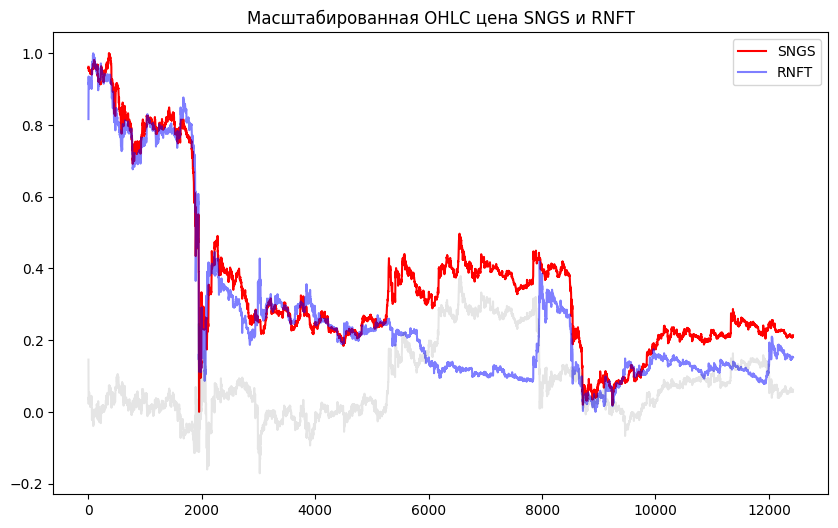

Показатель корреляции: 0.9122253759221479


In [ ]:
# Усредненная OHLC-цена
df_AB['OHLC_A'] = (df_AB['pr_open_A'] + df_AB['pr_close_A'] + df_AB['pr_high_A'] + df_AB['pr_low_A'])/4
df_AB['OHLC_B'] = (df_AB['pr_open_B'] + df_AB['pr_close_B'] + df_AB['pr_high_B'] + df_AB['pr_low_B'])/4

# Создаем колонку с масштабированной OHLC-ценой
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df_AB['OHLC_A_scaled'] = scaler.fit_transform(df_AB[['OHLC_A']])
df_AB['OHLC_B_scaled'] = scaler.fit_transform(df_AB[['OHLC_B']])

# Создаем колонку с масштабированным спредом
df_AB['spread_scaled'] = df_AB['OHLC_A_scaled'] - df_AB['OHLC_B_scaled']

# Считаем корреляцию
corr = df_AB['OHLC_A_scaled'].corr(df_AB['OHLC_B_scaled'])

# Выводим графики
plt.figure(figsize=(10, 6))
plt.plot(df_AB['OHLC_A_scaled'], color = "red")
plt.plot(df_AB['OHLC_B_scaled'], color="blue", alpha=0.5)
plt.plot(df_AB['spread_scaled'], color="black", alpha=0.1)
plt.title("Масштабированная OHLC цена "+df_AB['secid_A'].iloc[0]+' и '+df_AB['secid_B'].iloc[0], size = 12)
plt.legend([df_AB['secid_A'].iloc[0], df_AB['secid_B'].iloc[0]])
plt.show()

print('Показатель корреляции:',corr)

# Поиск корреляций внутри отраслей с сохранением в БД

Важный поинт в работе нашей торговой стратегии:

Искать корреляции нужно ТОЛЬКО между компаниями из одного сектора. Важно понимать, что существуют схожие распределения величин. Например, можно найти корреляцию между количеством мигрантов на Каймановы острова и деторождаемостью на Аляске. Это просто совпадение, на основании котрого мы не можем делать выводы.

Так же это работает и с акциями. На определенных интервалах можно обнаружить корреляцию между двумя инструментами из разных секторов экономики. Но выстраивать свою торговую стратегию на подобных парах не стоит.

Поэтому мы будем искать корреляцию только между акциями компаний из одного сектора экономики. Результаты будем сохранять в нашу БД и в Excel-файл.

In [ ]:
# Функция расчета корреляций
def starter_corr_finder(pair_tikers_list):
    # Выводим список уникальных комбинаций тикеров сектора
    print(pair_tikers_list)

    df_result_sector = pd.DataFrame(columns=['ticker_A', 'ticker_B', 'correlation', 'calc_dt'])

    for pair in pair_tikers_list:

        # Объявляем пару тикеров
        ticker_A = "'"+pair[0]+"'"
        ticker_B = "'"+pair[1]+"'"

        # Объявляем интервал дат
        begin_date = str(datetime.now() - timedelta(days=365))[:-15]+'00:00:00'
        end_date = str(datetime.now())[:-15]+'00:00:00'

        begin_date_formatted = "'"+begin_date+"'" #"'2022-01-01 00:00:00'"
        end_date_formatted = "'"+end_date+"'" #"'2023-01-01 00:00:00'"

        # Делаем запрос
        df_A = get_df_from_db(ticker_A, begin_date_formatted, end_date_formatted)
        df_B = get_df_from_db(ticker_B, begin_date_formatted, end_date_formatted)

        # Если какой-либо из датафреймов пуст, то переходим к следующей итерации
        if df_A.empty or df_B.empty:
            print('Корреляция', pair[0], pair[1], ': данные отсутствуют')
            continue

        # Склеиваем датафреймы
        df_AB = df_merger(df_A, df_B)

        # Усредненная OHLC-цена
        df_AB['OHLC_A'] = (df_AB['pr_open_A'] + df_AB['pr_close_A'] + df_AB['pr_high_A'] + df_AB['pr_low_A'])/4
        df_AB['OHLC_B'] = (df_AB['pr_open_B'] + df_AB['pr_close_B'] + df_AB['pr_high_B'] + df_AB['pr_low_B'])/4

        # Создаем колонку с масштабированной OHLC-ценой
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
        df_AB['OHLC_A_scaled'] = scaler.fit_transform(df_AB[['OHLC_A']])
        df_AB['OHLC_B_scaled'] = scaler.fit_transform(df_AB[['OHLC_B']])

        # Создаем колонку с масштабированным спредом
        #df_AB['spread_scaled'] = df_AB['OHLC_A_scaled'] - df_AB['OHLC_B_scaled']

        # Считаем корреляцию
        corr = round(df_AB['OHLC_A_scaled'].corr(df_AB['OHLC_B_scaled']),4)

        # Сохраняем результат в датафрейм
        df_result = pd.DataFrame(data={'ticker_A': [pair[0]], 'ticker_B': [pair[1]], 'correlation': [corr], 'calc_dt': [end_date]})
        df_result_sector = pd.concat([df_result_sector, df_result], axis=0, ignore_index=True)

        # Выводим статус
        print('Корреляция', pair[0], pair[1], ':', corr)

    # Сохраняемся в БД
    engine = create_engine(DB_ACCESS)
    lines_appended = df_result_sector.to_sql('correlations', engine, if_exists='append', chunksize=1000, schema='algo_pack', index=False)

    # Статус
    print('В БД добавлено', lines_appended, 'строк\n')

    return df_result_sector

In [ ]:
df_all_correlations = pd.DataFrame(columns=['ticker_A', 'ticker_B', 'correlation', 'calc_dt'])

# Перебираем сектора
for sector in sectors:

    # Выводим название сектора
    print(sector)

    # Создаем временный список для хранения тикеров сектора
    temporary_ticker_list = []

    # Перебираем справочник тикеров
    for ticker in dict_tickers:

        # Если нашелся тикер из текущего сектора, записываем его
        if dict_tickers[ticker][1] == sector:
            temporary_ticker_list.append(ticker)

    # Создаем список уникальных комбинаций тикеров сектора
    pair_tikers_list = itertools.combinations(temporary_ticker_list, 2)
    pair_tikers_list = list(pair_tikers_list)

    # Отправляем список пар на поиск корреляций
    df_correlations = starter_corr_finder(pair_tikers_list)

    # Сохраняем результат
    df_all_correlations = pd.concat([df_all_correlations, df_correlations], axis=0, ignore_index=True)

# Сохраняем результат в Excel
df_all_correlations.to_excel('df_all_correlations.xlsx')

print('Поиск корреляций завершен')
df_all_correlations

Уголь
[('RASP', 'BLNG')]
Корреляция RASP BLNG : 0.8547
В БД добавлено 1 строк

Розничная торговля
[('MGNT', 'FIXP'), ('MGNT', 'FIVE'), ('MGNT', 'MVID'), ('MGNT', 'LENT'), ('MGNT', 'OKEY'), ('MGNT', 'DSKY'), ('FIXP', 'FIVE'), ('FIXP', 'MVID'), ('FIXP', 'LENT'), ('FIXP', 'OKEY'), ('FIXP', 'DSKY'), ('FIVE', 'MVID'), ('FIVE', 'LENT'), ('FIVE', 'OKEY'), ('FIVE', 'DSKY'), ('MVID', 'LENT'), ('MVID', 'OKEY'), ('MVID', 'DSKY'), ('LENT', 'OKEY'), ('LENT', 'DSKY'), ('OKEY', 'DSKY')]
Корреляция MGNT FIXP : 0.4466
Корреляция MGNT FIVE : 0.9062
Корреляция MGNT MVID : 0.5105
Корреляция MGNT LENT : 0.4904
Корреляция MGNT OKEY : 0.8247
Корреляция MGNT DSKY : -0.0045
Корреляция FIXP FIVE : 0.4489
Корреляция FIXP MVID : 0.7672
Корреляция FIXP LENT : 0.8467
Корреляция FIXP OKEY : 0.6293
Корреляция FIXP DSKY : -0.0081
Корреляция FIVE MVID : 0.4642
Корреляция FIVE LENT : 0.3871
Корреляция FIVE OKEY : 0.8172
Корреляция FIVE DSKY : -0.1416
Корреляция MVID LENT : 0.8855
Корреляция MVID OKEY : 0.7854
Корреляция

# Подготовка данных для бэктеста со скользящим окном

Теперь нам нужно подготовить данные для бэктеста.

Чтобы бэктест был корректным, мы не можем произвести расчет линейной регрессии на всей имеющейся у нас выборке. Ведь мы должны имитировать реальную жизнь, в которой мы не знаем, куда двинется рынок завтра.

Поэтому мы поступим следующим образом:

1) возьмем данные из прошлого за 2 года

2) создадим скользящее окно размером 1 год

3) будем рассчитывать линейную регрессию на основе прошлых данных, прогнозируя по одной неделе вперед и двигая скользящее окно.

Так, как мы бы делали в реальной жизни.

Например, сегодня, мы берем данные за последний год, вычисляем на них линейную регрессию и прогнозируем её на 1 неделю вперед. Следующую неделю мы торгуем по спрогнозированной линейной регрессии. Потом повторяем. Таким образом мы постоянно будем двигаться вперед, прогнозируя 1 неделю.

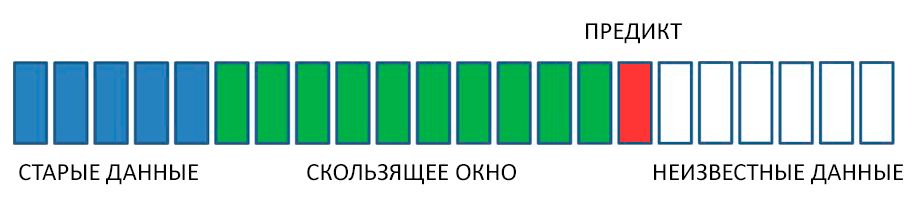

Все понедельно предсказанные таким образом кусочки линейной регрессии мы соберем в датафрейм, на основании которого и будем производить бэктестирование.

А еще, мы построим график, который позволит нам понять как ведет себя пара инструментов и позволит прикинуть подходящие гиперпараметры для работы нашей торговой системы.

Обратите внимание, что большинство бэктестов, которые исползуют алготрейдеры некорректны, ведь они просто адаптируют модель к историческим данным. Мы не такие. Наш бэктест будет работать исключительно на спрогнозированных данных.

Для дальнейшей работы мы будем использовать в качестве пары инструментов акции компаний Пик и Эталон, т.к. у них высокая степень корреляции.

In [ ]:
# Получение данных из БД
# Объявляем тикеры и интервал дат
ticker_A = "'"+"PIKK"+"'"
ticker_B = "'"+"ETLN"+"'"

# Задаем и "готовим" интервал дат
begin_date = '2021-12-01 00:00:00'
end_date = '2023-12-01 00:00:00'

begin_date = "'"+begin_date+"'"
end_date = "'"+end_date+"'"

# Сообщаем статус
print('Тикер А:', ticker_A)
print('Тикер B:', ticker_B)
print('Начальная дата:', begin_date)
print('Конечная дата:', end_date)

# Делаем запрос в БД
df_A = get_df_from_db(ticker_A, begin_date, end_date)
df_B = get_df_from_db(ticker_B, begin_date, end_date)

# Склеиваем полученные датафреймы
df_AB = df_merger(df_A, df_B)

# Задаем усредненную OHLC-цену
df_AB['OHLC_A'] = (df_AB['pr_open_A'] + df_AB['pr_close_A'] + df_AB['pr_high_A'] + df_AB['pr_low_A'])/4
df_AB['OHLC_B'] = (df_AB['pr_open_B'] + df_AB['pr_close_B'] + df_AB['pr_high_B'] + df_AB['pr_low_B'])/4

# Создаем пустые колонки для хранения результата
df_AB['spread_medium'] = ''
df_AB['OHLC_A_scaled'] = ''
df_AB['OHLC_B_scaled'] = ''
df_AB['spread_scaled'] = ''

Тикер А: 'PIKK'
Тикер B: 'ETLN'
Начальная дата: '2021-12-01 00:00:00'
Конечная дата: '2023-12-01 00:00:00'


In [ ]:
# Задаем размер скользящего окна (в днях)
SLIDING_WINDOW_SIZE = 365

# Задаем размер шага, на который мы будем сдвигать скользящее окно (в днях)
STEP_SIZE = 7

# Количество недель (включая неполные), которое прошло между началом и концом датасета
weeks_in_dataset = math.ceil((df_AB.iloc[-1]['begin_dt'] - df_AB.iloc[0]['begin_dt'])/timedelta(weeks=1))

# Вычисляем точку отсчета, начальную дату.
# Для этого отмеряем в глубину датасета от его конца недели.
start_dt = df_AB.iloc[-1]['begin_dt'] - timedelta(weeks=weeks_in_dataset)

# Вычисляем конечную дату
end_dt = start_dt + timedelta(days=SLIDING_WINDOW_SIZE)

# Обучаем линейную регрессию, смещая скользящее окно
for i in tqdm(range(math.ceil(weeks_in_dataset - SLIDING_WINDOW_SIZE/STEP_SIZE)+1)):

    # Наша обучающая выборка всегда короче на 1 шаг, чем полная
    train_end_dt = end_dt - timedelta(days=STEP_SIZE)

    # Нарезаем датасет с заданным шагом на куски размером со скользящее окно
    # на обучающую и плную выборку
    df_train = df_AB[(df_AB.begin_dt >= start_dt) & (df_AB.begin_dt <= train_end_dt)].copy(deep=True)
    df_work = df_AB[(df_AB.begin_dt >= start_dt) & (df_AB.begin_dt <= end_dt)].copy(deep=True)

#--------------------------
    # Создаем колонку с масштабированной OHLC-ценой
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_train['OHLC_A_scaled'] = scaler.fit_transform(df_train[['OHLC_A']])
    df_work['OHLC_A_scaled'] = scaler.transform(df_work[['OHLC_A']])
    df_train['OHLC_B_scaled'] = scaler.fit_transform(df_train[['OHLC_B']])
    df_work['OHLC_B_scaled'] = scaler.transform(df_work[['OHLC_B']])

    # Создаем колонку с масштабированным спредом
    df_train['spread_scaled'] = df_train['OHLC_B_scaled'] - df_train['OHLC_A_scaled']
    df_work['spread_scaled'] = df_work['OHLC_B_scaled'] - df_work['OHLC_A_scaled']

    # Создаем список значений X_train и y_train, но без последнего интервала
    X = np.arange(len(df_work)).reshape(-1, 1)
    X_train = np.arange(len(df_train)).reshape(-1, 1)
    y_train = df_train['spread_scaled']

    # Считаем средний спред при помощи линейной регрессии
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X)

    # Сохраняем результат
    df_work['spread_medium'] = y_pred

    # Обновляем значения в исходном датафрейме, записывая только последний шаг
    df_AB.loc[(df_AB.begin_dt >= train_end_dt) & (df_AB.begin_dt <= end_dt), 'spread_medium'] = df_work.loc[(df_work.begin_dt >= train_end_dt) & (df_work.begin_dt <= end_dt), 'spread_medium'].values
    df_AB.loc[(df_AB.begin_dt >= train_end_dt) & (df_AB.begin_dt <= end_dt), 'OHLC_A_scaled'] = df_work.loc[(df_work.begin_dt >= train_end_dt) & (df_work.begin_dt <= end_dt), 'OHLC_A_scaled'].values
    df_AB.loc[(df_AB.begin_dt >= train_end_dt) & (df_AB.begin_dt <= end_dt), 'OHLC_B_scaled'] = df_work.loc[(df_work.begin_dt >= train_end_dt) & (df_work.begin_dt <= end_dt), 'OHLC_B_scaled'].values
    df_AB.loc[(df_AB.begin_dt >= train_end_dt) & (df_AB.begin_dt <= end_dt), 'spread_scaled'] = df_work.loc[(df_work.begin_dt >= train_end_dt) & (df_work.begin_dt <= end_dt), 'spread_scaled'].values

#--------------------------
    # Делаем шаг, сдвигая скользящее окно
    start_dt += timedelta(days=STEP_SIZE)
    end_dt += timedelta(days=STEP_SIZE)

# Чистим память
del df_work, df_train

print('Линейная регрессия рассчитана')

100%|██████████| 54/54 [00:01<00:00, 45.76it/s]

Линейная регрессия рассчитана


In [ ]:
# Для этого отмеряем в глубину датасета от его конца недели.
start_dt = df_AB.iloc[-1]['begin_dt'] - timedelta(days=SLIDING_WINDOW_SIZE)

# Вычисляем конечную дату
end_dt = df_AB.iloc[-1]['begin_dt']

# Сохраняем подготовленные данные
df_for_backtest = df_AB[(df_AB.begin_dt >= start_dt) & (df_AB.begin_dt <= train_end_dt)]
df_for_backtest.reset_index(drop=True, inplace=True)
df_for_backtest

,secid_A,pr_open_A,pr_close_A,pr_high_A,pr_low_A,val_A,vol_A,begin_dt,end_dt_x,secid_B,...,pr_low_B,val_B,vol_B,end_dt_y,OHLC_A,OHLC_B,spread_medium,OHLC_A_scaled,OHLC_B_scaled,spread_scaled
0,PIKK,609.2,609.2,609.2,609.2,743224.0,1220.0,2022-11-30 18:40:00,2022-11-30 18:49:59,ETLN,...,48.94,20016.46,409.0,2022-11-30 18:48:02,609.200,48.940,-0.073395,0.249742,0.145262,-0.104481
1,PIKK,614.0,614.0,614.0,614.0,375768.0,612.0,2022-12-01 09:50:00,2022-12-01 09:59:59,ETLN,...,49.20,1377.60,28.0,2022-12-01 09:59:59,614.000,49.200,-0.073408,0.255238,0.14917,-0.106068
2,PIKK,614.1,611.9,614.2,611.1,2458744.2,4013.0,2022-12-01 10:00:00,2022-12-01 10:09:59,ETLN,...,48.96,561965.40,11361.0,2022-12-01 10:09:59,612.825,49.195,-0.073421,0.253892,0.149094,-0.104798
3,PIKK,612.0,612.0,612.3,611.0,1528470.6,2499.0,2022-12-01 10:10:00,2022-12-01 10:19:59,ETLN,...,49.20,117294.36,2379.0,2022-12-01 10:19:59,611.825,49.345,-0.073434,0.252748,0.151349,-0.101399
4,PIKK,612.0,612.6,612.8,611.6,516163.2,843.0,2022-12-01 10:20:00,2022-12-01 10:29:59,ETLN,...,49.32,429782.14,8676.0,2022-12-01 10:29:59,612.250,49.510,-0.073448,0.253234,0.153829,-0.099405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13550,PIKK,705.4,705.7,706.2,705.0,1406648.4,1993.0,2023-11-24 18:00:00,2023-11-24 18:09:59,ETLN,...,80.56,425203.60,5275.0,2023-11-24 18:09:59,705.575,80.680,0.220346,0.437609,0.667568,0.229958
13551,PIKK,705.9,704.9,705.9,704.9,137573.5,195.0,2023-11-24 18:10:00,2023-11-24 18:19:59,ETLN,...,80.50,501756.22,6227.0,2023-11-24 18:19:59,705.400,80.635,0.220365,0.436998,0.666699,0.229701
13552,PIKK,705.7,703.0,705.7,703.0,931647.6,1322.0,2023-11-24 18:20:00,2023-11-24 18:29:59,ETLN,...,80.46,333358.18,4140.0,2023-11-24 18:29:59,704.350,80.540,0.220383,0.433333,0.664865,0.231532
13553,PIKK,703.5,703.5,704.5,702.8,941009.8,1338.0,2023-11-24 18:30:00,2023-11-24 18:39:59,ETLN,...,80.56,835106.98,10345.0,2023-11-24 18:39:59,703.575,80.665,0.220402,0.430628,0.667278,0.23665


График это ОЧЕНЬ важно. Его внимательное изучение позволяет нам понять принцип, по которому движется пара инструментов и предположить рабочие параметры для нашей торговой системы.

На представленном ниже графике видно, как линейная регрессия идет "лесенкой". Каждая ступенька этой лесенки - неделя, спрогнозированная на основе предыдущего года.

Можно видеть, как сильно меняется линейная регрессия в течение года. Это суперважно, давайте это запомним. Для эффективной работы торговой стратегии, чем чаще мы будем пересчитывать линейную регрессию - тем лучше.

В целях оптимизации быстродействия во время хакатона мы пересчитываем линейную регрессию каждую неделю. Но если мы хотим улушить результаты нашей торговли, то можно сократить этот интервал, например до 1 дня.

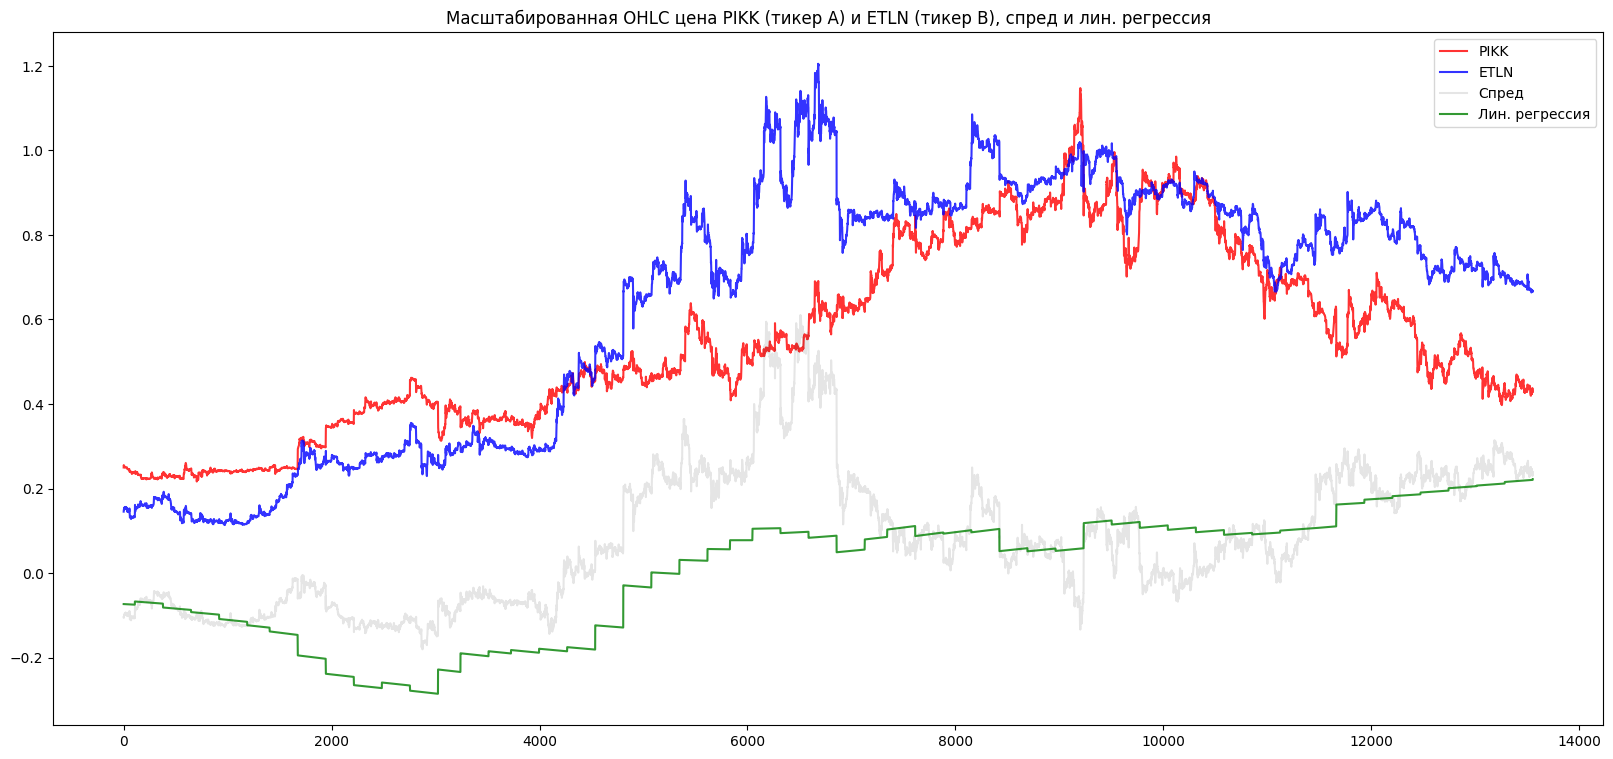

In [ ]:
# Выводим графики
legends = ['Спред','Лин. регрессия']
plt.figure(figsize=(20, 9))
plt.plot(df_for_backtest['OHLC_A_scaled'], color="red", alpha=0.8)
plt.plot(df_for_backtest['OHLC_B_scaled'], color="blue", alpha=0.8)
plt.plot(df_for_backtest['spread_scaled'], color="black", alpha=0.1)
plt.plot(df_for_backtest['spread_medium'], color="green", alpha=0.8)

plt.title("Масштабированная OHLC цена "+df_for_backtest['secid_A'].iloc[0]+' (тикер А) и '+df_for_backtest['secid_B'].iloc[0]+' (тикер B), спред и лин. регрессия', size = 12)
plt.legend([df_for_backtest['secid_A'].iloc[0], df_for_backtest['secid_B'].iloc[0], legends[0], legends[1]])

plt.show()

При помощи данного графика мы можем уже прикинуть параметры нашей торговой системы. Можно видеть в каких местах спред слишком убегает от нашей средней линии и в каких к ней возвращается.

In [ ]:
# Сохраняем данные для бэктеста
df_for_backtest.to_excel('/content/drive/MyDrive/Данные для DS/MoexHackaton/df_for_backtest.xlsx')

# Докрутка гиперпараметров

Графика вполне достаточно, чтобы получить рабочие параметры торговой системы. Но что если мы хотим их уточнить? Давайте создадим специальный механизм подбора гиперпараметров.

In [ ]:
# Подгружаем подготовленные данные
df_for_backtest = pd.read_excel('/content/drive/MyDrive/Данные для DS/MoexHackaton/df_for_backtest.xlsx', index_col=0)

In [ ]:
def backtest_search_params(
    df_AB,
    VARIANCE_POS_O,
    VARIANCE_POS_C,
    STOP_LOSS_A,
    TAKE_PROFIT_A,
    LOT_A,
    VARIANCE_NEG_O,
    VARIANCE_NEG_C,
    STOP_LOSS_B,
    TAKE_PROFIT_B,
    LOT_B,
    DEPOSIT,
    PART_TO_TRADE,
    COMISSION
             ):

    # Готовим столбцы
    df_AB['signal_o_A'] = 0         # Есть ли сигнал на открытие сделки по тикеру А
    df_AB['signal_c_A'] = 0         # Есть ли сигнал на закрытие сделки по тикеру А
    df_AB['takeprof_A'] = 0         # Есть ли сигнал по тейкпрофиту по тикеру А
    df_AB['stoploss_A'] = 0         # Есть ли сигнал по стоплоссу по тикеру А

    df_AB['opened_A'] = 0           # Статус открыта ли сделка по тикеру А
    df_AB['price_o_A'] = 0          # Цена по которой была открыта сделка по тикеру А
    df_AB['num_shares_A'] = 0       # Количество закупленных акций по тикеру А
    df_AB['buy_price_A'] = 0        # Цена покупки акций по тикеру А
    df_AB['sell_price_A'] = 0       # Цена продажи акций по тикеру А
    df_AB['bal_price_A'] = 0        # Текущая балансовая цена акций по тикеру А
    df_AB['cur_profit_A'] = 0       # Текущий профит по открытой сделке по тикеру А

    df_AB['signal_o_B'] = 0         # Есть ли сигнал на открытие сделки по тикеру B
    df_AB['signal_c_B'] = 0         # Есть ли сигнал на закрытие сделки по тикеру B
    df_AB['takeprof_B'] = 0         # Есть ли сигнал по тейкпрофиту по тикеру B
    df_AB['stoploss_B'] = 0         # Есть ли сигнал по стоплоссу по тикеру B

    df_AB['opened_B'] = 0           # Статус открыта ли сделка по тикеру B
    df_AB['price_o_B'] = 0          # Цена по которой была открыта сделка по тикеру B
    df_AB['num_shares_B'] = 0       # Количество закупленных акций по тикеру B
    df_AB['buy_price_B'] = 0        # Цена покупки акций по тикеру B
    df_AB['sell_price_B'] = 0       # Цена продажи акций по тикеру B
    df_AB['bal_price_B'] = 0        # Текущая балансовая цена акций по тикеру B
    df_AB['cur_profit_B'] = 0       # Текущий профит по открытой сделке по тикеру B

    df_AB['deposit'] = DEPOSIT      # Наш депозит
    df_AB['balance'] = 0            # Текущая балансовая оценка всех активов

    the_end = 0                     # Является ли строка последней

    # Перебираем каждую строку наших данных, постоянно обновляя статус
    for i in tqdm(range(len(df_AB))):

        # Записываем некоторые значения в переменные для удобства
        OHLC_A = df_AB.loc[i, 'OHLC_A']
        OHLC_B = df_AB.loc[i, 'OHLC_B']
        spread_scaled = df_AB.loc[i, 'spread_scaled']
        spread_medium = df_AB.loc[i, 'spread_medium']
        opened_A = df_AB.loc[i, 'opened_A']
        opened_B = df_AB.loc[i, 'opened_B']
        deposit = df_AB.loc[i, 'deposit']

        # Записываем остаток средства на депозите, начиная со второй строки
        if i > 0:
            df_AB.loc[i, 'deposit'] = df_AB.loc[i-1, 'deposit']

        # Если есть открытая сделка по тикеру А
        if opened_A == 1:

            # Записываем цену по которой была открыта сделка по тикеру А
            df_AB.loc[i, 'price_o_A'] = df_AB.loc[i-1, 'price_o_A']

            # Записываем количество купленных акций по тикеру А
            df_AB.loc[i, 'num_shares_A'] = df_AB.loc[i-1, 'num_shares_A']

            # Записываем сумму сделки покупки акций по тикеру А
            df_AB.loc[i, 'buy_price_A'] = df_AB.loc[i-1, 'buy_price_A']

            # Вычисляем и записываем текущую балансовую стоимость
            df_AB.loc[i, 'bal_price_A'] = OHLC_A * df_AB.loc[i, 'num_shares_A']

            # Вычисляем текущий профит по открытой сделке
            df_AB.loc[i, 'cur_profit_A'] = df_AB.loc[i, 'bal_price_A'] - df_AB.loc[i, 'buy_price_A']

            # Если текущий профит по сделке ушел в минус более, чем величина стоп-лосса
            if df_AB.loc[i, 'cur_profit_A'] < STOP_LOSS_A:
                df_AB.loc[i, 'stoploss_A'] = 1

            # Если текущий профит по сделке ушел в плюс более, чем величина тейкпрофита
            if df_AB.loc[i, 'cur_profit_A'] > TAKE_PROFIT_A:
                df_AB.loc[i, 'takeprof_A'] = 1

            # Есть ли торговый сигнал на закрытие по тикеру А
            if spread_scaled - spread_medium <= VARIANCE_POS_C:
                df_AB.loc[i, 'signal_c_A'] = 1

            # Это последняя строка, значит пора закрывать открытые сделки
            if i == len(df_AB)-1:
                the_end = 1

            # Проверяем есть ли хотя бы 1 сигнал на закрытие сделки по тикеру A
            if (df_AB.loc[i, 'signal_c_A'] == 1) | (df_AB.loc[i, 'takeprof_A'] == 1) | (df_AB.loc[i, 'stoploss_A'] == 1) | (the_end == 1):

                # Вычисляем и записываем цену закрытия с учетом комиссии
                df_AB.loc[i, 'sell_price_A'] = (df_AB.loc[i, 'num_shares_A'] * OHLC_A) - COMISSION * (df_AB.loc[i, 'num_shares_A'] * OHLC_A)

                # Обнуляем и записываем текущую балансовую стоимость
                df_AB.loc[i, 'bal_price_A'] = 0

                # Закрываем сделку по тикеру A. Распространяем до конца датафрейма
                df_AB.loc[i+1:,'opened_A'] = 0

                # Вычисляем и записываем остаток денежных средств на депозите
                df_AB.loc[i, 'deposit'] = df_AB.loc[i, 'deposit'] + df_AB.loc[i, 'bal_price_B'] + df_AB.loc[i, 'sell_price_A']

        # Если нет открытой сделки по тикеру A
        else:
            #print('Ждем сигнала')
            pass

            # Проверяем не пора ли открывать сделку по тикеру A
            if spread_scaled - spread_medium >= VARIANCE_POS_O:

                # Сохраняем сигнал на открытие по тикеру А
                df_AB.loc[i, 'signal_o_A'] = 1

                # Открываем сделку по тикеру A. Распространяем до конца датафрейма
                df_AB.loc[i:,'opened_A'] = 1

                # Вычисляем количество купленных акций
                df_AB.loc[i, 'num_shares_A'] = ((PART_TO_TRADE * deposit) // (OHLC_A * LOT_A)) * LOT_A

                # Записываем цену по которой была открыта сделка по тикеру А
                df_AB.loc[i, 'price_o_A'] = OHLC_A

                # Вычисляем и записываем сколько мы заплатили за покупку, включая комиссию брокера
                df_AB.loc[i, 'buy_price_A'] = OHLC_A * df_AB.loc[i, 'num_shares_A'] + COMISSION * OHLC_A * df_AB.loc[i, 'num_shares_A']

                # Вычисляем и записываем текущую балансовую стоимость
                df_AB.loc[i, 'bal_price_A'] = OHLC_A * df_AB.loc[i, 'num_shares_A']

                # Вычисляем текущий профит по открытой сделке
                df_AB.loc[i, 'cur_profit_A'] = df_AB.loc[i, 'bal_price_A'] - df_AB.loc[i, 'buy_price_A']

                # Вычисляем и записываем остаток денежных средств на депозите
                df_AB.loc[i, 'deposit'] = df_AB.loc[i, 'deposit'] - df_AB.loc[i, 'buy_price_A']

#--------------------------------------------

        # Если есть открытая сделка по тикеру B
        if opened_B == 1:

            # Записываем цену по которой была открыта сделка по тикеру B
            df_AB.loc[i, 'price_o_B'] = df_AB.loc[i-1, 'price_o_B']

            # Записываем количество купленных акций по тикеру B
            df_AB.loc[i, 'num_shares_B'] = df_AB.loc[i-1, 'num_shares_B']

            # Записываем сумму сделки покупки акций по тикеру А
            df_AB.loc[i, 'buy_price_B'] = df_AB.loc[i-1, 'buy_price_B']

            # Вычисляем и записываем текущую балансовую стоимость
            df_AB.loc[i, 'bal_price_B'] = OHLC_B * df_AB.loc[i, 'num_shares_B']

            # Вычисляем текущий профит по открытой сделке
            df_AB.loc[i, 'cur_profit_B'] = df_AB.loc[i, 'bal_price_B'] - df_AB.loc[i, 'buy_price_B']

            # Если текущий профит по сделке ушел в минус более, чем величина стоп-лосса
            if df_AB.loc[i, 'cur_profit_B'] < STOP_LOSS_B:
                df_AB.loc[i, 'stoploss_B'] = 1

            # Если текущий профит по сделке ушел в плюс более, чем величина тейкпрофита
            if df_AB.loc[i, 'cur_profit_B'] > TAKE_PROFIT_B:
                df_AB.loc[i, 'takeprof_B'] = 1

            # Есть ли торговый сигнал на закрытие по тикеру B
            if spread_medium - spread_scaled <= VARIANCE_NEG_C:
                df_AB.loc[i, 'signal_c_B'] = 1

            # Это последняя строка, значит пора закрывать открытые сделки
            if i == len(df_AB)-1:
                the_end = 1

            # Проверяем есть ли хотя бы 1 сигнал на закрытие сделки по тикеру B
            if (df_AB.loc[i, 'signal_c_B'] == 1) | (df_AB.loc[i, 'takeprof_B'] == 1) | (df_AB.loc[i, 'stoploss_B'] == 1) | (the_end == 1):

                # Вычисляем и записываем цену закрытия с учетом комиссии
                df_AB.loc[i, 'sell_price_B'] = (df_AB.loc[i, 'num_shares_B'] * OHLC_B) - COMISSION * (df_AB.loc[i, 'num_shares_B'] * OHLC_B)

                # Обнуляем и записываем текущую балансовую стоимость
                df_AB.loc[i, 'bal_price_B'] = 0

                # Закрываем сделку по тикеру B. Распространяем до конца датафрейма
                df_AB.loc[i+1:,'opened_B'] = 0

                # Вычисляем и записываем остаток денежных средств на депозите
                df_AB.loc[i, 'deposit'] = df_AB.loc[i, 'deposit'] + df_AB.loc[i, 'bal_price_A'] + df_AB.loc[i, 'sell_price_B']

        # Если нет открытой сделки по тикеру B
        else:
            #print('Ждем сигнала')
            pass

            # Проверяем не пора ли открывать сделку по тикеру B
            if spread_medium - spread_scaled >= VARIANCE_NEG_O:

                # Сохраняем сигнал на открытие
                df_AB.loc[i, 'signal_o_B'] = 1

                # Открываем сделку по тикеру B. Распространяем до конца датафрейма
                df_AB.loc[i:,'opened_B'] = 1

                # Вычисляем и записываем количество купленных акций
                df_AB.loc[i, 'num_shares_B'] = ((PART_TO_TRADE * deposit) // (OHLC_B * LOT_B)) * LOT_B

                # Записываем цену по которой была открыта сделка по тикеру B
                df_AB.loc[i, 'price_o_B'] = OHLC_B

                # Вычисляем и записываем сколько мы заплатили за покупку, включая комиссию брокера
                df_AB.loc[i, 'buy_price_B'] = OHLC_B * df_AB.loc[i, 'num_shares_B'] + COMISSION * OHLC_B * df_AB.loc[i, 'num_shares_B']

                # Вычисляем и записываем текущую балансовую стоимость
                df_AB.loc[i, 'bal_price_B'] = OHLC_B * df_AB.loc[i, 'num_shares_B']

                # Вычисляем текущий профит по открытой сделке
                df_AB.loc[i, 'cur_profit_B'] = df_AB.loc[i, 'bal_price_B'] - df_AB.loc[i, 'buy_price_B']

                # Вычисляем и записываем остаток денежных средств на депозите
                df_AB.loc[i, 'deposit'] = df_AB.loc[i, 'deposit'] - df_AB.loc[i, 'buy_price_B']

        # Вычисляем и записываем текущую балансовую стоимость всех активов
        df_AB.loc[i, 'balance'] = df_AB.loc[i, 'bal_price_A'] + df_AB.loc[i, 'bal_price_B'] + df_AB.loc[i, 'deposit']

    # Сделок по тикеру А (сделки открываются только по сигналу)
    trades_A = df_AB['signal_o_A'].sum()

    # Количество прибыльных сделок по тикеру A
    trades_profit_A = df_AB[df_AB['sell_price_A'] != 0]['cur_profit_A'].gt(0).sum()

    # Количество убыточных сделок по тикеру A
    trades_loss_A = df_AB[df_AB['sell_price_A'] != 0]['cur_profit_A'].lt(0).sum()

    # Суммарный доход по сделкам по тикеру А
    sum_income_A = df_AB[(df_AB['sell_price_A'] != 0) & (df_AB['cur_profit_A'] > 0)]['sell_price_A'].sum() - df_AB[(df_AB['sell_price_A'] != 0) & (df_AB['cur_profit_A'] > 0)]['buy_price_A'].sum()

    # Суммарный убыток по сделкам по тикеру А
    sum_waste_A = df_AB[(df_AB['sell_price_A'] != 0) & (df_AB['cur_profit_A'] < 0)]['sell_price_A'].sum() - df_AB[(df_AB['sell_price_A'] != 0) & (df_AB['cur_profit_A'] < 0)]['buy_price_A'].sum()

    # Сделок по тикеру B
    trades_B = df_AB['signal_o_B'].sum()

    # Количество прибыльных сделок по тикеру B
    trades_profit_B = df_AB[df_AB['sell_price_B'] != 0]['cur_profit_B'].gt(0).sum()

    # Количество убыточных сделок по тикеру B
    trades_loss_B = df_AB[df_AB['sell_price_B'] != 0]['cur_profit_B'].lt(0).sum()

    # Суммарный доход по сделкам по тикеру B
    sum_income_B = df_AB[(df_AB['sell_price_B'] != 0) & (df_AB['cur_profit_B'] > 0)]['sell_price_B'].sum() - df_AB[(df_AB['sell_price_B'] != 0) & (df_AB['cur_profit_B'] > 0)]['buy_price_B'].sum()

    # Суммарный убыток по сделкам по тикеру B
    sum_waste_B = df_AB[(df_AB['sell_price_B'] != 0) & (df_AB['cur_profit_B'] < 0)]['sell_price_B'].sum() - df_AB[(df_AB['sell_price_B'] != 0) & (df_AB['cur_profit_B'] < 0)]['buy_price_B'].sum()

    # Сделок по тикерам А и B
    trades_AB = df_AB['signal_o_A'].sum() + df_AB['signal_o_B'].sum()

    # Суммарный доход по сделкам по тикерам А и B
    sum_income_AB = sum_income_A + sum_income_B

    # Суммарный убыток по сделкам по тикерам А и B
    sum_waste_AB = sum_waste_A + sum_waste_B

    # Средняя величина убыточной сделки AVG DD
    avg_dd = round(sum_waste_AB / (trades_loss_A + trades_loss_B), 2)

    # Средняя величина прибыльной сделки Average win
    avg_win = round(sum_income_AB / (trades_profit_A + trades_profit_B), 2)

    # Profit Factor (Профит фактор)
    PF = round(sum_income_AB / abs(sum_waste_AB), 2)

    # Закрыто сделок по тейкпрофиту по тикерам A и B
    tp_done_AB = df_AB['takeprof_A'].sum() + df_AB['takeprof_B'].sum()

    # Закрыто сделок по стоплоссу по тикерам A и B
    sl_done_AB = df_AB['stoploss_A'].sum() + df_AB['stoploss_B'].sum()

    # Максимальная просадка балансовой стоимости портфеля в процентах (Drawdown)
    max_balance_loss_p = round(100*(df_AB['balance'].min() - DEPOSIT) / DEPOSIT, 2)

    # Профит в процентах
    profit_p = round(100*(df_AB['deposit'].iloc[-1] - DEPOSIT)/DEPOSIT,2)

    # Профит в рублях
    profit = round(df_AB['deposit'].iloc[-1] - DEPOSIT,2)

    return profit, profit_p, max_balance_loss_p, sl_done_AB, tp_done_AB, PF, avg_win, avg_dd, trades_AB

Здесь мы можем поэксперементировать на исторических данных, чтобы немного улучшить перформанс нашей стратегии.

Тем не менее помните, что гиперпараметры, подобранные на исторических данных не являются "вечными". Ведь условия рынка постепенно меняются. Поэтому мы рекомендуем периодичски прогонять модель на более свежих данных и слегка корректировать параметры. Если это делать регулярно, то настройки Вашей торговой системы будут всегда максимально релевантны к рыночным условиям.

Давайте через запятую укажем некоторые "соседние" величины и выберем оптимальные.

Для удобства результаты работы подборщика сохраняются в excel-файл.

In [ ]:
# ПАРАМЕТРЫ ТОРГОВОЙ СТРАТЕГИИ

# Тикер А
# Покупка. Положительное отклонение спреда от средней дисперсии
VARIANCE_POS_O = [0.09, 0.085, 0.095]
# Продажа. Положительное отклонение спреда от средней дисперсии
VARIANCE_POS_C = [0.01]
# Stop-loss. Указывается в рублях
STOP_LOSS_A = [-6250, -6200, -6300]
# Take-profit. Указывается в рублях
TAKE_PROFIT_A = [16400, 16500, 16600]
# Лотность тикера А
LOT_A = 1

# Тикер B
# Покупка. Отрицательное отклонение спреда от средней дисперсии
VARIANCE_NEG_O = [0.085]
# Продажа. Положительное отклонение спреда от средней дисперсии
VARIANCE_NEG_C = [0.01]
# Stop-loss. Указывается в рублях
STOP_LOSS_B = [-5500]
# Take-profit. Указывается в рублях
TAKE_PROFIT_B = [14000]
# Лотность тикера B
LOT_B = 1

# ПАРАМЕТРЫ БЭКТЕСТА
# Размер депозита
DEPOSIT = 1000000
# Доля депозита, на которую торгуем
PART_TO_TRADE = 0.20
# Комиссия брокера. Указывается в долях (НЕ в процентах)
COMISSION = 0.0053

In [ ]:
# Объявляем датафрейм для хранения результатов
df_summary = pd.DataFrame(columns =['set', 'params', 'profit', 'profit_p', 'max_balance_loss_p', 'sl_done_AB', 'tp_done_AB', 'PF', 'avg_win', 'avg_dd', 'trades_AB'])

# Объявляем счетчик
i = 1
combos = len(VARIANCE_POS_O)*len(VARIANCE_POS_C)*len(STOP_LOSS_A)*len(TAKE_PROFIT_A)*len(VARIANCE_NEG_O)*len(VARIANCE_NEG_C)*len(STOP_LOSS_B)*len(TAKE_PROFIT_B)

# Осуществляем перебор по сетке гиперпараметров
for vpo in VARIANCE_POS_O:
    for vpc in VARIANCE_POS_C:
        for sla in STOP_LOSS_A:
            for tpa in TAKE_PROFIT_A:
                for vno in VARIANCE_NEG_O:
                    for vnc in VARIANCE_NEG_C:
                        for slb in STOP_LOSS_B:
                            for tpb in TAKE_PROFIT_B:
                                print('\n',i,'/',combos)
                                profit, profit_p, max_balance_loss_p, sl_done_AB, tp_done_AB, PF, avg_win, avg_dd, trades_AB = backtest_search_params(df_for_backtest, vpo, vpc, sla, tpa, LOT_A, vno, vnc, slb, tpb, LOT_B, DEPOSIT, PART_TO_TRADE, COMISSION)
                                res = {
                                        'set': [i],
                                        'params': [str(vpo)+'_'+str(vpc)+'_'+str(sla)+'_'+str(tpa)+'_'+str(vno)+'_'+str(vnc)+'_'+str(slb)+'_'+str(tpb)],
                                        'profit': [profit],
                                        'profit_p': [profit_p],
                                        'max_balance_loss_p': [max_balance_loss_p],
                                        'sl_done_AB': [sl_done_AB],
                                        'tp_done_AB': [tp_done_AB],
                                        'PF': [PF],
                                        'avg_win': [avg_win],
                                        'avg_dd': [avg_dd],
                                        'trades_AB': [trades_AB]
                                        }
                                df_res = pd.DataFrame(data=res)
                                print('profit:', profit)
                                print('Результаты: profit_p:', profit_p, '| max_balance_loss_p:', max_balance_loss_p, '| sl_done_AB:', sl_done_AB, '| tp_done_AB:', tp_done_AB, '| PF:', PF, '| avg_win:', avg_win, '| avg_dd:', avg_dd, '| trades_AB:', trades_AB)
                                print('Гиперпараметры: VARIANCE_POS_O:',vpo,'| VARIANCE_POS_C:',vpc,'| STOP_LOSS_A:',sla,'| TAKE_PROFIT_A:',tpa,'| VARIANCE_NEG_O:',vno,'| VARIANCE_NEG_C:',vnc,'| STOP_LOSS_B:',slb,'| TAKE_PROFIT_B:',tpb)
                                df_summary = pd.concat([df_summary, df_res], axis=0, ignore_index=True)

                                i += 1

# Сохраняем результат в Excel
df_summary.to_excel('df_summary.xlsx')

# Сообщаем статус
print('Подбор гиперпараметров завершен!')


 1 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1213.55it/s]


profit: 68788.14
Результаты: profit_p: 6.88 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.42 | avg_win: 8834.86 | avg_dd: -7098.83 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.09 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6250 | TAKE_PROFIT_A: 16400 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 2 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1172.11it/s]


profit: 69525.81
Результаты: profit_p: 6.95 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.45 | avg_win: 8901.92 | avg_dd: -7098.83 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.09 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6250 | TAKE_PROFIT_A: 16500 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 3 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1174.16it/s]


profit: 69195.47
Результаты: profit_p: 6.92 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.4 | avg_win: 8907.89 | avg_dd: -7197.82 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.09 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6250 | TAKE_PROFIT_A: 16600 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 4 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1134.76it/s]


profit: 68366.31
Результаты: profit_p: 6.84 | max_balance_loss_p: -0.57 | sl_done_AB: 5 | tp_done_AB: 5 | PF: 2.92 | avg_win: 8668.99 | avg_dd: -7132.31 | trades_AB: 17
Гиперпараметры: VARIANCE_POS_O: 0.09 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6200 | TAKE_PROFIT_A: 16400 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 5 / 27


100%|██████████| 13555/13555 [00:10<00:00, 1285.84it/s]


profit: 68366.31
Результаты: profit_p: 6.84 | max_balance_loss_p: -0.57 | sl_done_AB: 5 | tp_done_AB: 5 | PF: 2.92 | avg_win: 8668.99 | avg_dd: -7132.31 | trades_AB: 17
Гиперпараметры: VARIANCE_POS_O: 0.09 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6200 | TAKE_PROFIT_A: 16500 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 6 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1209.70it/s]


profit: 69415.12
Результаты: profit_p: 6.94 | max_balance_loss_p: -0.57 | sl_done_AB: 5 | tp_done_AB: 5 | PF: 2.93 | avg_win: 8789.39 | avg_dd: -7211.51 | trades_AB: 17
Гиперпараметры: VARIANCE_POS_O: 0.09 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6200 | TAKE_PROFIT_A: 16600 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 7 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1180.19it/s]


profit: 68788.14
Результаты: profit_p: 6.88 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.42 | avg_win: 8834.86 | avg_dd: -7098.83 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.09 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6300 | TAKE_PROFIT_A: 16400 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 8 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1175.35it/s]


profit: 69525.81
Результаты: profit_p: 6.95 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.45 | avg_win: 8901.92 | avg_dd: -7098.83 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.09 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6300 | TAKE_PROFIT_A: 16500 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 9 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1181.09it/s]


profit: 69195.47
Результаты: profit_p: 6.92 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.4 | avg_win: 8907.89 | avg_dd: -7197.82 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.09 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6300 | TAKE_PROFIT_A: 16600 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 10 / 27


100%|██████████| 13555/13555 [00:10<00:00, 1273.69it/s]


profit: 68149.62
Результаты: profit_p: 6.81 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.29 | avg_win: 9789.93 | avg_dd: -5949.93 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.085 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6250 | TAKE_PROFIT_A: 16400 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 11 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1201.90it/s]


profit: 68887.29
Результаты: profit_p: 6.89 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.32 | avg_win: 9863.69 | avg_dd: -5949.93 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.085 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6250 | TAKE_PROFIT_A: 16500 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 12 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1170.29it/s]


profit: 68556.95
Результаты: profit_p: 6.86 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.27 | avg_win: 9870.26 | avg_dd: -6029.13 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.085 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6250 | TAKE_PROFIT_A: 16600 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 13 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1140.07it/s]


profit: 67727.79
Результаты: profit_p: 6.77 | max_balance_loss_p: -0.57 | sl_done_AB: 5 | tp_done_AB: 5 | PF: 2.83 | avg_win: 9522.15 | avg_dd: -6169.31 | trades_AB: 17
Гиперпараметры: VARIANCE_POS_O: 0.085 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6200 | TAKE_PROFIT_A: 16400 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 14 / 27


100%|██████████| 13555/13555 [00:12<00:00, 1128.33it/s]


profit: 67727.79
Результаты: profit_p: 6.77 | max_balance_loss_p: -0.57 | sl_done_AB: 5 | tp_done_AB: 5 | PF: 2.83 | avg_win: 9522.15 | avg_dd: -6169.31 | trades_AB: 17
Гиперпараметры: VARIANCE_POS_O: 0.085 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6200 | TAKE_PROFIT_A: 16500 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 15 / 27


100%|██████████| 13555/13555 [00:10<00:00, 1236.76it/s]


profit: 68776.6
Результаты: profit_p: 6.88 | max_balance_loss_p: -0.57 | sl_done_AB: 5 | tp_done_AB: 5 | PF: 2.84 | avg_win: 9653.5 | avg_dd: -6235.31 | trades_AB: 17
Гиперпараметры: VARIANCE_POS_O: 0.085 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6200 | TAKE_PROFIT_A: 16600 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 16 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1217.88it/s]


profit: 68149.62
Результаты: profit_p: 6.81 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.29 | avg_win: 9789.93 | avg_dd: -5949.93 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.085 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6300 | TAKE_PROFIT_A: 16400 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 17 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1178.38it/s]


profit: 68887.29
Результаты: profit_p: 6.89 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.32 | avg_win: 9863.69 | avg_dd: -5949.93 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.085 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6300 | TAKE_PROFIT_A: 16500 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 18 / 27


100%|██████████| 13555/13555 [00:12<00:00, 1067.71it/s]


profit: 68556.95
Результаты: profit_p: 6.86 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.27 | avg_win: 9870.26 | avg_dd: -6029.13 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.085 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6300 | TAKE_PROFIT_A: 16600 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 19 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1169.39it/s]


profit: 68788.14
Результаты: profit_p: 6.88 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.42 | avg_win: 8834.86 | avg_dd: -7098.83 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.095 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6250 | TAKE_PROFIT_A: 16400 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 20 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1214.20it/s]


profit: 69525.81
Результаты: profit_p: 6.95 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.45 | avg_win: 8901.92 | avg_dd: -7098.83 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.095 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6250 | TAKE_PROFIT_A: 16500 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 21 / 27


100%|██████████| 13555/13555 [00:10<00:00, 1262.79it/s]


profit: 69195.47
Результаты: profit_p: 6.92 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.4 | avg_win: 8907.89 | avg_dd: -7197.82 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.095 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6250 | TAKE_PROFIT_A: 16600 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 22 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1181.27it/s]


profit: 68366.31
Результаты: profit_p: 6.84 | max_balance_loss_p: -0.57 | sl_done_AB: 5 | tp_done_AB: 5 | PF: 2.92 | avg_win: 8668.99 | avg_dd: -7132.31 | trades_AB: 17
Гиперпараметры: VARIANCE_POS_O: 0.095 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6200 | TAKE_PROFIT_A: 16400 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 23 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1175.95it/s]


profit: 68366.31
Результаты: profit_p: 6.84 | max_balance_loss_p: -0.57 | sl_done_AB: 5 | tp_done_AB: 5 | PF: 2.92 | avg_win: 8668.99 | avg_dd: -7132.31 | trades_AB: 17
Гиперпараметры: VARIANCE_POS_O: 0.095 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6200 | TAKE_PROFIT_A: 16500 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 24 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1175.10it/s]


profit: 69415.12
Результаты: profit_p: 6.94 | max_balance_loss_p: -0.57 | sl_done_AB: 5 | tp_done_AB: 5 | PF: 2.93 | avg_win: 8789.39 | avg_dd: -7211.51 | trades_AB: 17
Гиперпараметры: VARIANCE_POS_O: 0.095 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6200 | TAKE_PROFIT_A: 16600 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 25 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1222.52it/s]


profit: 68788.14
Результаты: profit_p: 6.88 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.42 | avg_win: 8834.86 | avg_dd: -7098.83 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.095 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6300 | TAKE_PROFIT_A: 16400 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 26 / 27


100%|██████████| 13555/13555 [00:10<00:00, 1260.07it/s]


profit: 69525.81
Результаты: profit_p: 6.95 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.45 | avg_win: 8901.92 | avg_dd: -7098.83 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.095 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6300 | TAKE_PROFIT_A: 16500 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000

 27 / 27


100%|██████████| 13555/13555 [00:11<00:00, 1177.89it/s]

profit: 69195.47
Результаты: profit_p: 6.92 | max_balance_loss_p: -0.57 | sl_done_AB: 4 | tp_done_AB: 5 | PF: 3.4 | avg_win: 8907.89 | avg_dd: -7197.82 | trades_AB: 15
Гиперпараметры: VARIANCE_POS_O: 0.095 | VARIANCE_POS_C: 0.01 | STOP_LOSS_A: -6300 | TAKE_PROFIT_A: 16600 | VARIANCE_NEG_O: 0.085 | VARIANCE_NEG_C: 0.01 | STOP_LOSS_B: -5500 | TAKE_PROFIT_B: 14000
Подбор гиперпараметров завершен!


# Бэктестер

Напишем бэктестер, который производит расчет перформанса торговой стратегии по заданным параметрам.

Наш бэктестер будет сильно напоминать механизм докрутки гиперпараметров, который мы использовали выше. Они и правда очень похожи, хотя и решают разные задачи.

Наш бэктестер будет производить расчет 42 (!) показателей. Но самые важные из них это показатель прибыли и Profit Factor. Именно на эти цифры алготрейдеры обращают внимание в первую очередь. Ну и естественно мы построим кривую капитала (Equity), чтобы наглядно посмотреть, что будет происходить с нашим депозитом.

Мы будем производить бэктестирование на заранее подготовленных данных, которые исключают возможность "подсмотреть" будущие котировки. Это очень важно.

ВНИМАНИЕ!
Отдельного комментария заслуживает размер депозита. Для теста мы взяли депозит 1 млн рублей. Но в торговле задействуем только 20% депозита. Это классический прием risk money management, но в нашем кокретном случае он не является необходимостью. Дело в том, что мы жестко ограничиваем убыток при помощи stoplossa. Наши показатели таковы:

Максимальная просадка балансовой стоимости портфеля (руб): -5695.52

Максимальная просадка балансовой стоимости портфеля (Drawdown) (%): -0.57

Таким образом, мы могли бы использовать для торговля депозит размером около 210 тыс. рублей и получить абсолютно ту же доходность. Помните, что правила risk money management у каждого алготрейдера свои.

In [ ]:
# Подгружаем подготовленные данные
df_for_backtest = pd.read_excel('/content/drive/MyDrive/Данные для DS/MoexHackaton/df_for_backtest.xlsx', index_col=0)

In [ ]:
# ПАРАМЕТРЫ ТОРГОВОЙ СТРАТЕГИИ

# Тикер А
# Покупка. Положительное отклонение спреда от средней дисперсии
VARIANCE_POS_O = 0.09
# Продажа. Положительное отклонение спреда от средней дисперсии
VARIANCE_POS_C = 0.01
# Stop-loss. Указывается в рублях
STOP_LOSS_A = -6250
# Take-profit. Указывается в рублях
TAKE_PROFIT_A = 16500
# Лотность тикера А
LOT_A = 1

# Тикер B
# Покупка. Отрицательное отклонение спреда от средней дисперсии
VARIANCE_NEG_O = 0.085
# Продажа. Положительное отклонение спреда от средней дисперсии
VARIANCE_NEG_C = 0.01
# Stop-loss. Указывается в рублях
STOP_LOSS_B = -5500
# Take-profit. Указывается в рублях
TAKE_PROFIT_B = 14000
# Лотность тикера B
LOT_B = 1

# ПАРАМЕТРЫ БЭКТЕСТА
# Размер депозита
DEPOSIT = 1000000
# Доля депозита, на которую торгуем
PART_TO_TRADE = 0.20
# Комиссия брокера. Указывается в долях (НЕ в процентах)
COMISSION = 0.0053

In [ ]:
def backtest(
    df_AB,
    VARIANCE_POS_O,
    VARIANCE_POS_C,
    STOP_LOSS_A,
    TAKE_PROFIT_A,
    LOT_A,
    VARIANCE_NEG_O,
    VARIANCE_NEG_C,
    STOP_LOSS_B,
    TAKE_PROFIT_B,
    LOT_B,
    DEPOSIT,
    PART_TO_TRADE,
    COMISSION
             ):

    # Готовим столбцы
    df_AB['signal_o_A'] = 0         # Есть ли сигнал на открытие сделки по тикеру А
    df_AB['signal_c_A'] = 0         # Есть ли сигнал на закрытие сделки по тикеру А
    df_AB['takeprof_A'] = 0         # Есть ли сигнал по тейкпрофиту по тикеру А
    df_AB['stoploss_A'] = 0         # Есть ли сигнал по стоплоссу по тикеру А

    df_AB['opened_A'] = 0           # Статус открыта ли сделка по тикеру А
    df_AB['price_o_A'] = 0          # Цена по которой была открыта сделка по тикеру А
    df_AB['num_shares_A'] = 0       # Количество закупленных акций по тикеру А
    df_AB['buy_price_A'] = 0        # Цена покупки акций по тикеру А
    df_AB['sell_price_A'] = 0       # Цена продажи акций по тикеру А
    df_AB['bal_price_A'] = 0        # Текущая балансовая цена акций по тикеру А
    df_AB['cur_profit_A'] = 0       # Текущий профит по открытой сделке по тикеру А

    df_AB['signal_o_B'] = 0         # Есть ли сигнал на открытие сделки по тикеру B
    df_AB['signal_c_B'] = 0         # Есть ли сигнал на закрытие сделки по тикеру B
    df_AB['takeprof_B'] = 0         # Есть ли сигнал по тейкпрофиту по тикеру B
    df_AB['stoploss_B'] = 0         # Есть ли сигнал по стоплоссу по тикеру B

    df_AB['opened_B'] = 0           # Статус открыта ли сделка по тикеру B
    df_AB['price_o_B'] = 0          # Цена по которой была открыта сделка по тикеру B
    df_AB['num_shares_B'] = 0       # Количество закупленных акций по тикеру B
    df_AB['buy_price_B'] = 0        # Цена покупки акций по тикеру B
    df_AB['sell_price_B'] = 0       # Цена продажи акций по тикеру B
    df_AB['bal_price_B'] = 0        # Текущая балансовая цена акций по тикеру B
    df_AB['cur_profit_B'] = 0       # Текущий профит по открытой сделке по тикеру B

    df_AB['deposit'] = DEPOSIT      # Наш депозит
    df_AB['balance'] = 0            # Текущая балансовая оценка всех активов

    the_end = 0                     # Является ли строка последней

    # Перебираем каждую строку наших данных, постоянно обновляя статус
    for i in tqdm(range(len(df_AB))):

        # Записываем некоторые значения в переменные для удобства
        OHLC_A = df_AB.loc[i, 'OHLC_A']
        OHLC_B = df_AB.loc[i, 'OHLC_B']
        spread_scaled = df_AB.loc[i, 'spread_scaled']
        spread_medium = df_AB.loc[i, 'spread_medium']
        opened_A = df_AB.loc[i, 'opened_A']
        opened_B = df_AB.loc[i, 'opened_B']
        deposit = df_AB.loc[i, 'deposit']

        # Записываем остаток средства на депозите, начиная со второй строки
        if i > 0:
            df_AB.loc[i, 'deposit'] = df_AB.loc[i-1, 'deposit']

        # Если есть открытая сделка по тикеру А
        if opened_A == 1:

            # Записываем цену по которой была открыта сделка по тикеру А
            df_AB.loc[i, 'price_o_A'] = df_AB.loc[i-1, 'price_o_A']

            # Записываем количество купленных акций по тикеру А
            df_AB.loc[i, 'num_shares_A'] = df_AB.loc[i-1, 'num_shares_A']

            # Записываем сумму сделки покупки акций по тикеру А
            df_AB.loc[i, 'buy_price_A'] = df_AB.loc[i-1, 'buy_price_A']

            # Вычисляем и записываем текущую балансовую стоимость
            df_AB.loc[i, 'bal_price_A'] = OHLC_A * df_AB.loc[i, 'num_shares_A']

            # Вычисляем текущий профит по открытой сделке
            df_AB.loc[i, 'cur_profit_A'] = df_AB.loc[i, 'bal_price_A'] - df_AB.loc[i, 'buy_price_A']

            # Если текущий профит по сделке ушел в минус более, чем величина стоп-лосса
            if df_AB.loc[i, 'cur_profit_A'] < STOP_LOSS_A:
                df_AB.loc[i, 'stoploss_A'] = 1

            # Если текущий профит по сделке ушел в плюс более, чем величина тейкпрофита
            if df_AB.loc[i, 'cur_profit_A'] > TAKE_PROFIT_A:
                df_AB.loc[i, 'takeprof_A'] = 1

            # Есть ли торговый сигнал на закрытие по тикеру А
            if spread_scaled - spread_medium <= VARIANCE_POS_C:
                df_AB.loc[i, 'signal_c_A'] = 1

            # Это последняя строка, значит пора закрывать открытые сделки
            if i == len(df_AB)-1:
                the_end = 1

            # Проверяем есть ли хотя бы 1 сигнал на закрытие сделки по тикеру A
            if (df_AB.loc[i, 'signal_c_A'] == 1) | (df_AB.loc[i, 'takeprof_A'] == 1) | (df_AB.loc[i, 'stoploss_A'] == 1) | (the_end == 1):

                # Вычисляем и записываем цену закрытия с учетом комиссии
                df_AB.loc[i, 'sell_price_A'] = (df_AB.loc[i, 'num_shares_A'] * OHLC_A) - COMISSION * (df_AB.loc[i, 'num_shares_A'] * OHLC_A)

                # Обнуляем и записываем текущую балансовую стоимость
                df_AB.loc[i, 'bal_price_A'] = 0

                # Закрываем сделку по тикеру A. Распространяем до конца датафрейма
                df_AB.loc[i+1:,'opened_A'] = 0

                # Вычисляем и записываем остаток денежных средств на депозите
                df_AB.loc[i, 'deposit'] = df_AB.loc[i, 'deposit'] + df_AB.loc[i, 'bal_price_B'] + df_AB.loc[i, 'sell_price_A']

                #print('Закрыта сделка по тикеру А')

        # Если нет открытой сделки по тикеру A
        else:
            #print('Ждем сигнала')
            pass

            # Проверяем не пора ли открывать сделку по тикеру A
            if spread_scaled - spread_medium >= VARIANCE_POS_O:

                # Сохраняем сигнал на открытие по тикеру А
                df_AB.loc[i, 'signal_o_A'] = 1

                # Открываем сделку по тикеру A. Распространяем до конца датафрейма
                df_AB.loc[i:,'opened_A'] = 1

                # Вычисляем количество купленных акций
                df_AB.loc[i, 'num_shares_A'] = ((PART_TO_TRADE * deposit) // (OHLC_A * LOT_A)) * LOT_A

                # Записываем цену по которой была открыта сделка по тикеру А
                df_AB.loc[i, 'price_o_A'] = OHLC_A

                # Вычисляем и записываем сколько мы заплатили за покупку, включая комиссию брокера
                df_AB.loc[i, 'buy_price_A'] = OHLC_A * df_AB.loc[i, 'num_shares_A'] + COMISSION * OHLC_A * df_AB.loc[i, 'num_shares_A']

                # Вычисляем и записываем текущую балансовую стоимость
                df_AB.loc[i, 'bal_price_A'] = OHLC_A * df_AB.loc[i, 'num_shares_A']

                # Вычисляем текущий профит по открытой сделке
                df_AB.loc[i, 'cur_profit_A'] = df_AB.loc[i, 'bal_price_A'] - df_AB.loc[i, 'buy_price_A']

                # Вычисляем и записываем остаток денежных средств на депозите
                df_AB.loc[i, 'deposit'] = df_AB.loc[i, 'deposit'] - df_AB.loc[i, 'buy_price_A']

                #print('Открыта сделка по тикеру А')


    #--------------------------------------------

        # Если есть открытая сделка по тикеру B
        if opened_B == 1:

            # Записываем цену по которой была открыта сделка по тикеру B
            df_AB.loc[i, 'price_o_B'] = df_AB.loc[i-1, 'price_o_B']

            # Записываем количество купленных акций по тикеру B
            df_AB.loc[i, 'num_shares_B'] = df_AB.loc[i-1, 'num_shares_B']

            # Записываем сумму сделки покупки акций по тикеру А
            df_AB.loc[i, 'buy_price_B'] = df_AB.loc[i-1, 'buy_price_B']

            # Вычисляем и записываем текущую балансовую стоимость
            df_AB.loc[i, 'bal_price_B'] = OHLC_B * df_AB.loc[i, 'num_shares_B']

            # Вычисляем текущий профит по открытой сделке
            df_AB.loc[i, 'cur_profit_B'] = df_AB.loc[i, 'bal_price_B'] - df_AB.loc[i, 'buy_price_B']

            # Если текущий профит по сделке ушел в минус более, чем величина стоп-лосса
            if df_AB.loc[i, 'cur_profit_B'] < STOP_LOSS_B:
                df_AB.loc[i, 'stoploss_B'] = 1

            # Если текущий профит по сделке ушел в плюс более, чем величина тейкпрофита
            if df_AB.loc[i, 'cur_profit_B'] > TAKE_PROFIT_B:
                df_AB.loc[i, 'takeprof_B'] = 1

            # Есть ли торговый сигнал на закрытие по тикеру B
            if spread_medium - spread_scaled <= VARIANCE_NEG_C:
                df_AB.loc[i, 'signal_c_B'] = 1

            # Это последняя строка, значит пора закрывать открытые сделки
            if i == len(df_AB)-1:
                the_end = 1

            # Проверяем есть ли хотя бы 1 сигнал на закрытие сделки по тикеру B
            if (df_AB.loc[i, 'signal_c_B'] == 1) | (df_AB.loc[i, 'takeprof_B'] == 1) | (df_AB.loc[i, 'stoploss_B'] == 1) | (the_end == 1):

                # Вычисляем и записываем цену закрытия с учетом комиссии
                df_AB.loc[i, 'sell_price_B'] = (df_AB.loc[i, 'num_shares_B'] * OHLC_B) - COMISSION * (df_AB.loc[i, 'num_shares_B'] * OHLC_B)

                # Обнуляем и записываем текущую балансовую стоимость
                df_AB.loc[i, 'bal_price_B'] = 0

                # Закрываем сделку по тикеру B. Распространяем до конца датафрейма
                df_AB.loc[i+1:,'opened_B'] = 0

                # Вычисляем и записываем остаток денежных средств на депозите
                df_AB.loc[i, 'deposit'] = df_AB.loc[i, 'deposit'] + df_AB.loc[i, 'bal_price_A'] + df_AB.loc[i, 'sell_price_B']

                #print('Закрыта сделка по тикеру B')

        # Если нет открытой сделки по тикеру B
        else:
            #print('Ждем сигнала')
            pass

            # Проверяем не пора ли открывать сделку по тикеру B
            if spread_medium - spread_scaled >= VARIANCE_NEG_O:

                # Сохраняем сигнал на открытие
                df_AB.loc[i, 'signal_o_B'] = 1

                # Открываем сделку по тикеру B. Распространяем до конца датафрейма
                df_AB.loc[i:,'opened_B'] = 1

                # Вычисляем и записываем количество купленных акций
                df_AB.loc[i, 'num_shares_B'] = ((PART_TO_TRADE * deposit) // (OHLC_B * LOT_B)) * LOT_B

                # Записываем цену по которой была открыта сделка по тикеру B
                df_AB.loc[i, 'price_o_B'] = OHLC_B

                # Вычисляем и записываем сколько мы заплатили за покупку, включая комиссию брокера
                df_AB.loc[i, 'buy_price_B'] = OHLC_B * df_AB.loc[i, 'num_shares_B'] + COMISSION * OHLC_B * df_AB.loc[i, 'num_shares_B']

                # Вычисляем и записываем текущую балансовую стоимость
                df_AB.loc[i, 'bal_price_B'] = OHLC_B * df_AB.loc[i, 'num_shares_B']

                # Вычисляем текущий профит по открытой сделке
                df_AB.loc[i, 'cur_profit_B'] = df_AB.loc[i, 'bal_price_B'] - df_AB.loc[i, 'buy_price_B']

                # Вычисляем и записываем остаток денежных средств на депозите
                df_AB.loc[i, 'deposit'] = df_AB.loc[i, 'deposit'] - df_AB.loc[i, 'buy_price_B']

                #print('Открыта сделка по тикеру B')

        # Вычисляем и записываем текущую балансовую стоимость всех активов
        df_AB.loc[i, 'balance'] = df_AB.loc[i, 'bal_price_A'] + df_AB.loc[i, 'bal_price_B'] + df_AB.loc[i, 'deposit']

    #-------------------
    # Вводные данные

    # ТИКЕР А
    print('')
    print('Сигнал на покупку тикера A. Положительное отклонение спреда от средней дисперсии:', VARIANCE_POS_O)
    print('Cигнал на продажу тикера A. Положительное отклонение спреда от средней дисперсии:', VARIANCE_POS_C)
    print('Сигнал stoploss тикера A (в рублях):', STOP_LOSS_A)
    print('Сигнал takeprofit тикера A (в рублях):', TAKE_PROFIT_A)
    print('Лотность тикера А:', LOT_A)

    # ТИКЕР B
    print('Сигнал на покупку тикера B. Отрицательное отклонение спреда от средней дисперсии:', VARIANCE_NEG_O)
    print('Cигнал на продажу тикера B. Положительное отклонение спреда от средней дисперсии:', VARIANCE_NEG_C)
    print('Сигнал stoploss тикера B (в рублях):', STOP_LOSS_B)
    print('Сигнал takeprofit тикера B (в рублях):', TAKE_PROFIT_B)
    print('Лотность тикера B:', LOT_B)

    # ПАРАМЕТРЫ БЭКТЕСТА
    print('Размер депозита:', DEPOSIT)
    print('Доля депозита, на которую торгуем:', PART_TO_TRADE)
    print('Комиссия брокера (в долях, НЕ в процентах):', COMISSION)
    print('-------------')

    #-------------------
    # Расчетные статистические данные

    # Сделок по тикеру А (сделки открываются только по сигналу)
    trades_A = df_AB['signal_o_A'].sum()
    print('Всего сделок по тикеру А:', trades_A)

    # Количество прибыльных сделок по тикеру A
    trades_profit_A = df_AB[df_AB['sell_price_A'] != 0]['cur_profit_A'].gt(0).sum()
    print('Прибыльных сделок по тикеру A:', trades_profit_A)

    # Количество убыточных сделок по тикеру A
    trades_loss_A = df_AB[df_AB['sell_price_A'] != 0]['cur_profit_A'].lt(0).sum()
    print('Убыточных сделок по тикеру A:', trades_loss_A)

    # Самая прибыльная сделка по тикеру A
    trades_profit_max_A = round((df_AB[df_AB['sell_price_A'] != 0]['sell_price_A'] - df_AB[df_AB['sell_price_A'] != 0]['buy_price_A']).max(),2)
    print('Самая прибыльная сделка по тикеру A:', trades_profit_max_A)

    # Самая убыточная сделка по тикеру A
    trades_profit_min_A = round((df_AB[df_AB['sell_price_A'] != 0]['sell_price_A'] - df_AB[df_AB['sell_price_A'] != 0]['buy_price_A']).min(),2)
    print('Самая убыточная сделка по тикеру A:', trades_profit_min_A)

    # Самая дорогая сделка по тикеру A
    trades_expensive_a = df_AB[df_AB['buy_price_A'] > 0]['buy_price_A'].max()
    print('Самая дорогая сделка по тикеру A:', trades_expensive_a)

    # Самая дешевая сделка по тикеру A
    trades_cheap_a = df_AB[df_AB['buy_price_A'] > 0]['buy_price_A'].min()
    print('Самая дешевая сделка по тикеру A:', trades_cheap_a)

    # Суммарный доход по сделкам по тикеру А
    sum_income_A = df_AB[(df_AB['sell_price_A'] != 0) & (df_AB['cur_profit_A'] > 0)]['sell_price_A'].sum() - df_AB[(df_AB['sell_price_A'] != 0) & (df_AB['cur_profit_A'] > 0)]['buy_price_A'].sum()
    print('Суммарный доход по сделкам по тикеру А:', sum_income_A)

    # Суммарный убыток по сделкам по тикеру А
    sum_waste_A = df_AB[(df_AB['sell_price_A'] != 0) & (df_AB['cur_profit_A'] < 0)]['sell_price_A'].sum() - df_AB[(df_AB['sell_price_A'] != 0) & (df_AB['cur_profit_A'] < 0)]['buy_price_A'].sum()
    print('Суммарный убыток по сделкам по тикеру А:', sum_waste_A)

    # Сделок по тикеру B
    trades_B = df_AB['signal_o_B'].sum()
    print('Всего сделок по тикеру B:', trades_B)

    # Количество прибыльных сделок по тикеру B
    trades_profit_B = df_AB[df_AB['sell_price_B'] != 0]['cur_profit_B'].gt(0).sum()
    print('Прибыльных сделок по тикеру B:', trades_profit_B)

    # Количество убыточных сделок по тикеру B
    trades_loss_B = df_AB[df_AB['sell_price_B'] != 0]['cur_profit_B'].lt(0).sum()
    print('Убыточных сделок по тикеру B:', trades_loss_B)

    # Самая прибыльная сделка по тикеру B
    trades_profit_max_B = round((df_AB[df_AB['sell_price_B'] != 0]['sell_price_B'] - df_AB[df_AB['sell_price_B'] != 0]['buy_price_B']).max(),2)
    print('Самая прибыльная сделка по тикеру B:', trades_profit_max_B)

    # Самая убыточная сделка по тикеру B
    trades_profit_min_B = round((df_AB[df_AB['sell_price_B'] != 0]['sell_price_B'] - df_AB[df_AB['sell_price_B'] != 0]['buy_price_B']).min(),2)
    print('Самая убыточная сделка по тикеру B:', trades_profit_min_B)

    # Самая дорогая сделка по тикеру B
    trades_expensive_b = df_AB[df_AB['buy_price_B'] > 0]['buy_price_B'].max()
    print('Самая дорогая сделка по тикеру B:', trades_expensive_b)

    # Самая дешевая сделка по тикеру B
    trades_cheap_b = df_AB[df_AB['buy_price_B'] > 0]['buy_price_B'].min()
    print('Самая дешевая сделка по тикеру B:', trades_cheap_b)

    # Суммарный доход по сделкам по тикеру B
    sum_income_B = df_AB[(df_AB['sell_price_B'] != 0) & (df_AB['cur_profit_B'] > 0)]['sell_price_B'].sum() - df_AB[(df_AB['sell_price_B'] != 0) & (df_AB['cur_profit_B'] > 0)]['buy_price_B'].sum()
    print('Суммарный доход по сделкам по тикеру B:', sum_income_B)

    # Суммарный убыток по сделкам по тикеру B
    sum_waste_B = df_AB[(df_AB['sell_price_B'] != 0) & (df_AB['cur_profit_B'] < 0)]['sell_price_B'].sum() - df_AB[(df_AB['sell_price_B'] != 0) & (df_AB['cur_profit_B'] < 0)]['buy_price_B'].sum()
    print('Суммарный убыток по сделкам по тикеру B:', sum_waste_B)

    # Сделок по тикерам А и B
    trades_AB = df_AB['signal_o_A'].sum() + df_AB['signal_o_B'].sum()
    print('Всего сделок по тикерам А и B:', trades_AB)

    # Суммарный доход по сделкам по тикерам А и B
    sum_income_AB = sum_income_A + sum_income_B
    print('Суммарный доход по сделкам по тикерам А и B:', sum_income_AB)

    # Суммарный убыток по сделкам по тикерам А и B
    sum_waste_AB = sum_waste_A + sum_waste_B
    print('Суммарный убыток по сделкам по тикерам А и B:', sum_waste_AB)

    # Средняя величина убыточной сделки AVG DD
    avg_dd = round(sum_waste_AB / (trades_loss_A + trades_loss_B), 2)
    print('Средняя величина убыточной сделки AVG DD:', avg_dd)

    # Средняя величина прибыльной сделки Average win
    avg_win = round(sum_income_AB / (trades_profit_A + trades_profit_B), 2)
    print('Средняя величина прибыльной сделки Average win:', avg_win)

    # Net Profit / Net Loss
    NP_NL = round((sum_income_AB + sum_waste_AB) / DEPOSIT, 2)
    print('Net Profit/Net Loss:', NP_NL)

    # Profit Factor (Профит фактор)
    PF = round(sum_income_AB / abs(sum_waste_AB), 2)
    print('Profit Factor (Профит фактор):', PF)

    # Authentic Profit Factor (Достоверный профит фактор)
    APF = round((sum_income_AB - max(trades_profit_max_B, trades_profit_max_A))/ abs(sum_waste_AB), 2)
    print('Authentic Profit Factor (Достоверный профит фактор):', APF)

    # Закрыто сделок по тейкпрофиту по тикеру А
    tp_done_A = df_AB['takeprof_A'].sum()
    print('Досрочно закрыто сделок по тейкпрофиту по тикеру А:', tp_done_A)

    # Закрыто сделок по тейкпрофиту по тикеру B
    tp_done_B = df_AB['takeprof_B'].sum()
    print('Досрочно закрыто сделок по тейкпрофиту по тикеру B:', tp_done_B)

    # Закрыто сделок по тейкпрофиту по тикерам A и B
    tp_done_AB = df_AB['takeprof_A'].sum() + df_AB['takeprof_B'].sum()
    print('Досрочно закрыто сделок по тейкпрофиту по тикерам A и B:', tp_done_AB)

    # Закрыто сделок по стоплоссу по тикеру А
    sl_done_A = df_AB['stoploss_A'].sum()
    print('Досрочно закрыто сделок по стоплоссу по тикеру А:', sl_done_A)

    # Закрыто сделок по стоплоссу по тикеру B
    sl_done_B = df_AB['stoploss_B'].sum()
    print('Досрочно закрыто сделок по стоплоссу по тикеру B:', sl_done_B)

    # Закрыто сделок по стоплоссу по тикерам A и B
    sl_done_AB = df_AB['stoploss_A'].sum() + df_AB['stoploss_B'].sum()
    print('Досрочно закрыто сделок по стоплоссу по тикерам A и B:', sl_done_AB)

    # Время пребывания в сделке по тикеру A в свечах
    candles_A = df_AB['opened_A'].sum()
    print('Время пребывания в сделках по тикеру A в свечах:', candles_A)

    # Время пребывания в сделке по тикеру B в свечах
    candles_B = df_AB['opened_B'].sum()
    print('Время пребывания в сделках по тикеру B в свечах:', candles_B)

    # Время пребывания в сделке по тикеру B в свечах
    candles_AB = df_AB['opened_A'].sum() + df_AB['opened_B'].sum()
    print('Время пребывания в сделках по тикерам A и B:', candles_AB)

    # Максимальная загрузка депозита
    max_deposit_load = round(100 * max(trades_expensive_a, trades_expensive_b) / DEPOSIT, 2)
    print('Максимальная загрузка депозита (%):', max_deposit_load)

    # Максимальная просадка балансовой стоимости портфеля в рублях
    max_balance_loss = round(df_AB['balance'].min() - DEPOSIT, 2)
    print('Максимальная просадка балансовой стоимости портфеля (руб):', max_balance_loss)

    # Максимальная просадка балансовой стоимости портфеля в процентах (Drawdown)
    max_balance_loss_p = round(100*(df_AB['balance'].min() - DEPOSIT) / DEPOSIT, 2)
    print('Максимальная просадка балансовой стоимости портфеля (Drawdown) (%):', max_balance_loss_p)

    # Максимальный профит балансовой стоимости портфеля в рублях
    max_balance_profit = round(df_AB['balance'].max() - DEPOSIT, 2)
    print('Максимальный профит балансовой стоимости портфеля (руб):', max_balance_profit)

    # Максимальный профит балансовой стоимости портфеля в процентах
    max_balance_profit_p = round(100*(df_AB['balance'].max() - DEPOSIT) / DEPOSIT, 2)
    print('Максимальный профит балансовой стоимости портфеля (%):', max_balance_profit_p)

    # Профит в процентах
    profit_p = round(100*(df_AB['deposit'].iloc[-1] - DEPOSIT)/DEPOSIT,2)
    print('Прибыль (%):', profit_p)

    # Профит в рублях
    profit = round(df_AB['deposit'].iloc[-1] - DEPOSIT,2)
    print('Прибыль (руб):', profit)

    # Выводим график Equity (график кривой капитала)
    plt.figure(figsize=(10, 6))
    plt.plot(df_AB['begin_dt'], df_AB['balance'], color= 'green')
    plt.title('Equity (Кривая капитала)', size = 12)
    plt.show()

    # Сохраняем результат
    df_AB.to_excel('backtest.xlsx')

    print('\nГотово!')

100%|██████████| 13555/13555 [00:10<00:00, 1235.33it/s]



Сигнал на покупку тикера A. Положительное отклонение спреда от средней дисперсии: 0.09
Cигнал на продажу тикера A. Положительное отклонение спреда от средней дисперсии: 0.01
Сигнал stoploss тикера A (в рублях): -6250
Сигнал takeprofit тикера A (в рублях): 16500
Лотность тикера А: 1
Сигнал на покупку тикера B. Отрицательное отклонение спреда от средней дисперсии: 0.085
Cигнал на продажу тикера B. Положительное отклонение спреда от средней дисперсии: 0.01
Сигнал stoploss тикера B (в рублях): -5500
Сигнал takeprofit тикера B (в рублях): 14000
Лотность тикера B: 1
Размер депозита: 1000000
Доля депозита, на которую торгуем: 0.2
Комиссия брокера (в долях, НЕ в процентах): 0.0053
-------------
Всего сделок по тикеру А: 10
Прибыльных сделок по тикеру A: 8
Убыточных сделок по тикеру A: 2
Самая прибыльная сделка по тикеру A: 17142.51
Самая убыточная сделка по тикеру A: -7591.52
Самая дорогая сделка по тикеру A: 201026.09625749997
Самая дешевая сделка по тикеру A: 200346.237
Суммарный доход по с

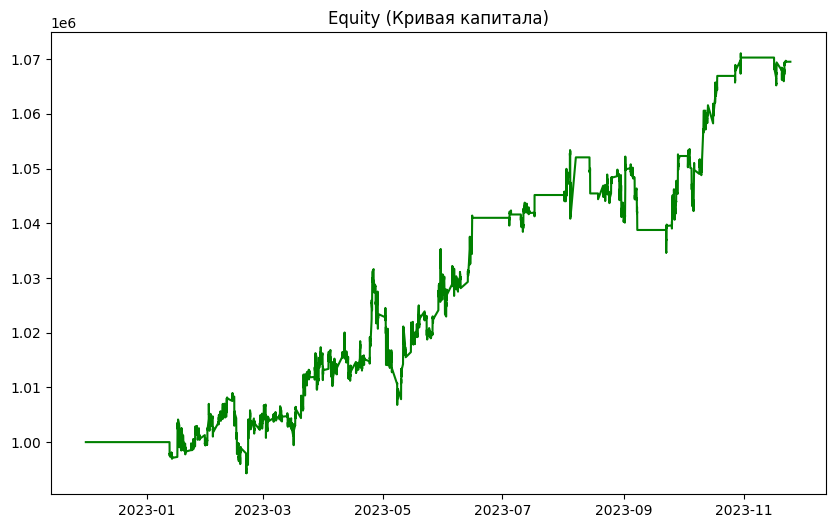


Готово!


In [ ]:
# Осуществляем бэктест для обучающей выборки
backtest(
    df_for_backtest,
    VARIANCE_POS_O,
    VARIANCE_POS_C,
    STOP_LOSS_A,
    TAKE_PROFIT_A,
    LOT_A,
    VARIANCE_NEG_O,
    VARIANCE_NEG_C,
    STOP_LOSS_B,
    TAKE_PROFIT_B,
    LOT_B,
    DEPOSIT,
    PART_TO_TRADE,
    COMISSION
    )

# Интеграция с брокером Тинькофф

Подготовим ряд функций для корректной работы с брокером.

Во-первых, нам понадобится инструмент для определения глобального идентификатора финансового инструмента (Financial Instrument Global Identifier) - сокращенно FIGI.

Во-вторых, нам необходимы инструменты для открытия и закрытия позиций.

Ну и в-третьих, нам необходим инструмент для выставления стоп-ордеров.

Мы реализуем данный функционал через брокера Тинькофф. Хотя при желании мы можем использовать любого другого брокера. Это непринципиально.

In [ ]:
# Получение FIGI по тикерам
def get_figi(ticker):

    with Client(TOKEN) as client:
        instruments: InstrumentsService = client.instruments
        tickers = []
        for method in ["shares", "bonds", "etfs", "currencies", "futures"]:
            for item in getattr(instruments, method)().instruments:
                tickers.append(
                    {
                        "name": item.name,
                        "ticker": item.ticker,
                        "class_code": item.class_code,
                        "figi": item.figi,
                        "uid": item.uid,
                        "type": method,
                        "min_price_increment": quotation_to_decimal(
                            item.min_price_increment
                        ),
                        "scale": 9 - len(str(item.min_price_increment.nano)) + 1,
                        "lot": item.lot,
                        "trading_status": str(
                            SecurityTradingStatus(item.trading_status).name
                        ),
                        "api_trade_available_flag": item.api_trade_available_flag,
                        "currency": item.currency,
                        "exchange": item.exchange,
                        "buy_available_flag": item.buy_available_flag,
                        "sell_available_flag": item.sell_available_flag,
                        "short_enabled_flag": item.short_enabled_flag,
                        "klong": quotation_to_decimal(item.klong),
                        "kshort": quotation_to_decimal(item.kshort),
                    }
                )

        tickers_df = pd.DataFrame(tickers)

        ticker_df = tickers_df[tickers_df["ticker"] == ticker]
        if ticker_df.empty:
            print('Такого тикера не существует!')
            return

        # Получаем код
        figi = ticker_df["figi"].iloc[0]

    return figi


# Функция размещения ордера на покупку
def make_order_buy(instrument_code, quantity, take_profit, stop_loss):

    # Статус
    print('Внимание! Используется боевой торговый счет!')

    with Client(TOKEN, target=INVEST_GRPC_API) as client:

        # Готовимся к отправке ордера
        response = client.users.get_accounts()

        account, *_ = response.accounts
        account_id = account.id

        # Генерируем id ордера
        order_id = uuid.uuid4().hex

        # Статус
        print('Размещаю ордер на покупку лотов в количестве',quantity,'для инструмента',instrument_code,'номер ордера',order_id)

        # Пробуем разместить ордер
        try:
            post_order_response: PostOrderResponse = client.orders.post_order(
                quantity=quantity,
                direction=OrderDirection.ORDER_DIRECTION_BUY,
                account_id=account_id,
                order_type=OrderType.ORDER_TYPE_MARKET,
                order_id=order_id,
                instrument_id=instrument_code,
            )

            # Получаем статус по ордеру
            status = post_order_response.execution_report_status
        except:
            status = 'Ошибка размещения ордера на покупку'
            print("Что-то пошло не так! Возможно сейчас просто выходные?")

        if status == OrderExecutionReportStatus.EXECUTION_REPORT_STATUS_FILL:
            # Статус
            print('Ордер был исполнен, размещаю стоп-ордер')

            # Если основной ордер был исполнен, выставляем стоп-ордера
            post_stop_orders(instrument_code, quantity, take_profit, stop_loss, client=client, account_id=account_id, post_order_response=post_order_response)
        else:
            # Статус
            print('Ордер не был исполнен:',status)

# Функция размещения стоп-ордеров
def post_stop_orders(instrument_code, quantity, take_profit, stop_loss, client: Services, account_id: str, post_order_response: PostOrderResponse):

    # Вычисляем цену исполнения основного ордера
    executed_order_price = money_to_decimal(post_order_response.executed_order_price)

    # Вычисляем цену тейкпрофита
    take_profit_price = executed_order_price + take_profit

    # Отправляем запрос на выставление тейкпрофита
    take_profit_response = client.stop_orders.post_stop_order(
        quantity=quantity,
        price=decimal_to_quotation(take_profit_price),
        stop_price=decimal_to_quotation(take_profit_price),
        direction=StopOrderDirection.STOP_ORDER_DIRECTION_SELL,
        account_id=account_id,
        stop_order_type=StopOrderType.STOP_ORDER_TYPE_TAKE_PROFIT,
        instrument_id=instrument_code,
        expire_date=now() + STOP_ORDER_EXPIRE_DURATION,
        expiration_type=EXPIRATION_TYPE,
    )

    # Статус
    print('Ордер тейк-профит с id',take_profit_response.stop_order_id,'был размещен по цене',take_profit_price)

    # Вычисляем цену стоплосса
    stop_loss_price = executed_order_price - stop_loss

    # Отправляем запрос на выставление тейкпрофита стоплосса
    take_profit_response = client.stop_orders.post_stop_order(
        quantity=quantity,
        stop_price=decimal_to_quotation(stop_loss_price),
        direction=StopOrderDirection.STOP_ORDER_DIRECTION_SELL,
        account_id=account_id,
        stop_order_type=StopOrderType.STOP_ORDER_TYPE_STOP_LOSS,
        instrument_id=instrument_code,
        expire_date=now() + STOP_ORDER_EXPIRE_DURATION,
        expiration_type=EXPIRATION_TYPE,
    )

    print('Ордер стоп-лосс с id',take_profit_response.stop_order_id,'был размещен по цене',stop_loss_price)


# Функция размещения ордера на продажу
def make_order_sell(instrument_code, quantity):

    # Статус
    print('Используется боевой торговый счет')

    with Client(TOKEN) as client:

        # Готовимся к отправке ордера
        response = client.users.get_accounts()
        account, *_ = response.accounts
        account_id = account.id

        # Вычисляем id ордера
        order_id = uuid.uuid4().hex

        # Статус
        print('Размещаю ордер на продажу лотов в количестве',quantity,'для инструмента',instrument_code,'номер ордера',order_id)

        # Пробуем разместить ордер
        try:
            post_order_response: PostOrderResponse = client.orders.post_order(
                quantity=quantity,
                direction=OrderDirection.ORDER_DIRECTION_SELL,
                account_id=account_id,
                order_type=OrderType.ORDER_TYPE_MARKET,
                order_id=order_id,
                instrument_id=instrument_code,
            )

            # Получаем статус по ордеру
            status = post_order_response.execution_report_status
        except:
            status = 'Ошибка размещения ордера на продажу'
            print("Что-то пошло не так! Возможно сейчас просто выходные?")


        if status == OrderExecutionReportStatus.EXECUTION_REPORT_STATUS_FILL:
            # Статус
            print('Ордер на продажу размещен')

            # Отмена всех ордеров
            client.cancel_all_orders(account_id=account_id)

        else:
            # Статус
            print('Ордер не был исполнен:',status)

# Работа торговой стратегии

Для реальной работы торговой стратегии мы пойдем на бескомпромиссные улучшения:

1) Будем собирать расширенные данные из AlgoPack при помощи метода tradestats. Это позволит нам в будущем улучшать работу торговой системы, добавляя в неё новые элементы, ведь tradestats отдает значительно больше данных, чем содержат обычные OHLCV-данные.

2) Перейдем на работу с 10-минутного на 5-минутный интервал. Это позволит нашей торговой системе более чутко реагировать на поток данных. Например, повысит эффективность работы стоплоссов.

3) Мы будем обновлять данные по линейной регрессии не 1 раз в неделю, как мы делали это на тесте, а 1 раз в 5 минут. Данный подход увеличит вычислительную нагрузку на сервер, но позволит нам повысить эффективность работы торговой системы, сделав её более гибкой и адаптивной.

In [ ]:
# Функция получения всех свечных данных для тикера
def candles_for_pair_tickers(ticker_A, ticker_B):

    # Объявляем абсурдно раннюю дату и сегодняшнюю дату и дату годом ранее
    end_date = str(date.today())
    start_date = str(date.today() - timedelta(days=365))

    # Получаем данные для нашей пары тикеров
    current_ticker_A = Ticker(ticker_A)
    df_A = current_ticker_A.tradestats(date=start_date, till_date=end_date)
    current_ticker_B = Ticker(ticker_B)
    df_B = current_ticker_B.tradestats(date=start_date, till_date=end_date)

    # Объединяем дату и время в один столбец
    df_A['begin_dt'] = df_A['tradedate'].combine(df_A['tradetime'], lambda x,y: datetime.combine(x, y))
    df_B['begin_dt'] = df_B['tradedate'].combine(df_B['tradetime'], lambda x,y: datetime.combine(x, y))

    # На всякий случай отсортируем и приведем в порядок индексы
    df_A.sort_values(by='begin_dt', inplace=True)
    df_A.reset_index(drop=True, inplace=True)
    df_B.sort_values(by='begin_dt', inplace=True)
    df_B.reset_index(drop=True, inplace=True)

    # Убираем столбцы, которые нам пока не нужны
    df_A.drop(["tradedate", "tradetime", "pr_std", "vol", "val", "trades", "pr_vwap", "pr_change", "trades_b", "trades_s", "val_b", "val_s", "vol_b", "vol_s", "disb", "pr_vwap_b", "pr_vwap_s", "systime"], axis=1, inplace=True)
    df_B.drop(["tradedate", "tradetime", "pr_std", "vol", "val", "trades", "pr_vwap", "pr_change", "trades_b", "trades_s", "val_b", "val_s", "vol_b", "vol_s", "disb", "pr_vwap_b", "pr_vwap_s", "systime"], axis=1, inplace=True)

    # Переименовываем столбцы
    df_A.rename(columns={
        'ticker': 'secid_A',
        'pr_open': 'pr_open_A',
        'pr_close': 'pr_close_A',
        'pr_high': 'pr_high_A',
        'pr_low': 'pr_low_A',
        }, inplace=True)

    # Переименовываем столбцы
    df_B.rename(columns={
        'secid': 'secid_B',
        'pr_open': 'pr_open_B',
        'pr_close': 'pr_close_B',
        'pr_high': 'pr_high_B',
        'pr_low': 'pr_low_B',
        }, inplace=True)

    # Пересекаем датафреймы
    df_AB = pd.merge(df_A, df_B, how='inner', on=['begin_dt'])

    # Задаем усредненную OHLC-цену
    df_AB['OHLC_A'] = (df_AB['pr_open_A'] + df_AB['pr_close_A'] + df_AB['pr_high_A'] + df_AB['pr_low_A'])/4
    df_AB['OHLC_B'] = (df_AB['pr_open_B'] + df_AB['pr_close_B'] + df_AB['pr_high_B'] + df_AB['pr_low_B'])/4

    # Создаем колонку с масштабированной OHLC-ценой
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    df_AB['OHLC_A_scaled'] = scaler.fit_transform(df_AB[['OHLC_A']])
    df_AB['OHLC_B_scaled'] = scaler.fit_transform(df_AB[['OHLC_B']])

    # Создаем колонку с масштабированным спредом
    df_AB['spread_scaled'] = df_AB['OHLC_B_scaled'] - df_AB['OHLC_A_scaled']

    # Создаем список значений X и y
    X = np.arange(len(df_AB)).reshape(-1, 1)
    y = df_AB['spread_scaled']

    # Считаем средний спред при помощи линейной регрессии
    reg = LinearRegression().fit(X, y)
    df_AB['spread_medium'] = reg.predict(X)

    return df_AB


# Наша торговая система, дающая сигналы на открытие и закрытие сделок по паре
def trade_system(
    df_AB,
    VARIANCE_POS_O,
    VARIANCE_POS_C,
    VARIANCE_NEG_O,
    VARIANCE_NEG_C,
             ):

    # Для обнаружения сигнала берем самую последнюю свечу
    spread_scaled = df_AB[-1:]['spread_scaled'].values[0]
    spread_medium = df_AB[-1:]['spread_medium'].values[0]

    # Проверяем не пора ли открывать сделку по тикеру A
    if spread_scaled - spread_medium >= VARIANCE_POS_O:
        print('Есть сигнал на открытие по тикеру А!')
        return 1

    # Есть ли торговый сигнал на закрытие по тикеру А
    if spread_scaled - spread_medium <= VARIANCE_POS_C:
        print('Есть сигнал на закрытие по тикеру А!')
        return 2

    # Проверяем не пора ли открывать сделку по тикеру B
    if spread_medium - spread_scaled >= VARIANCE_NEG_O:
        print('Есть сигнал на открытие по тикеру B!')
        return 3

    # Есть ли торговый сигнал на закрытие по тикеру B
    if spread_medium - spread_scaled <= VARIANCE_NEG_C:
        print('Есть сигнал на закрытие по тикеру B!')
        return 4

Зададим рабочие параметры нашей торговой системы. В качестве торговй пары будем использовать акции компаний ПИК и Эталон.

In [ ]:
# Задаем нашу торговую пару
ticker_A = 'PIKK'
ticker_B = 'ETLN'

# Получаем FIGI от Тинькофф
figi_A = get_figi(ticker_A)
figi_B = get_figi(ticker_B)

# ПАРАМЕТРЫ ТОРГОВОЙ СТРАТЕГИИ

# Тикер А
# Покупка. Положительное отклонение спреда от средней дисперсии
VARIANCE_POS_O = 0.09
# Продажа. Положительное отклонение спреда от средней дисперсии
VARIANCE_POS_C = 0.01
# Stop-loss. Указывается в рублях
STOP_LOSS_A = -6250
# Take-profit. Указывается в рублях
TAKE_PROFIT_A = 16500
# Лотность тикера А
LOT_A = 1

# Тикер B
# Покупка. Отрицательное отклонение спреда от средней дисперсии
VARIANCE_NEG_O = 0.085
# Продажа. Положительное отклонение спреда от средней дисперсии
VARIANCE_NEG_C = 0.01
# Stop-loss. Указывается в рублях
STOP_LOSS_B = -5500
# Take-profit. Указывается в рублях
TAKE_PROFIT_B = 14000
# Лотность тикера B
LOT_B = 1

# Размер депозита
DEPOSIT = 1000000
# Доля депозита, на которую торгуем
PART_TO_TRADE = 0.20
# Комиссия брокера. Указывается в долях (НЕ в процентах)
COMISSION = 0.0053

# Время жизни ордера
STOP_ORDER_EXPIRE_DURATION = timedelta(hours=1)
EXPIRATION_TYPE = StopOrderExpirationType.STOP_ORDER_EXPIRATION_TYPE_GOOD_TILL_DATE

Ниже представлен основной рабочий цикл, который 1 раз в 5 минут запрашивает данные с МосБиржи, производит расчет линейной регрессии и выдает сигнал на открытие/закрытие сделок по торговой паре.

Работа цикла организована через GoogleColab. Но при желании её можно реализовать в файле *.py, запускаемом вручную или по cron-планировщику.

In [ ]:
# Задаем время в секундах между запуском робота. 300 - 1 раз в 5 минут
time_interval = 300

# Объявляем счетчик выполнения
counter = 0

# Перед началом работы объявляем статусы сделок по нашей торговой паре
opened_A = 0
opened_B = 0

# Крутим бесконечный цикл
while True:
    # Обновляем и выводим счетчик
    counter+=1
    print('Число запусков бота:',counter)

    # Получаем и готовим данные по паре
    df_AB = candles_for_pair_tickers(ticker_A, ticker_B)

    # Запрашиваем торговый сигнал у нашей торговой системы
    signal = trade_system(df_AB, VARIANCE_POS_O, VARIANCE_POS_C, VARIANCE_NEG_O, VARIANCE_NEG_C)

    # Есть сигнал на открытие по тикеру А
    if signal == 1:
        if opened_A == 1:
            print('Сделка по тикеру А уже открыта')
        else:
            print('Открываю сделку по тикеру А')

            # Создаем ордер на покупку, выставляем стоплосс и тейкпрофит (PIKK)
            make_order_buy(instrument_code=figi_A, quantity=360, take_profit=TAKE_PROFIT_A, stop_loss=STOP_LOSS_A)
            opened_A = 1

    # Есть сигнал на закрытие по тикеру А
    elif signal == 2:
        if opened_A == 0:
            print('Сделка по тикеру А уже закрыта')
        else:
            print('Закрываю сделку по тикеру А')

            # Создаем ордер на продажу (PIKK)
            make_order_sell(instrument_code=figi_A, quantity=360)
            opened_A = 0

    # Есть сигнал на открытие по тикеру B
    elif signal == 3:
        if opened_B == 1:
            print('Сделка по тикеру B уже открыта')
        else:
            print('Открываю сделку по тикеру B')

            # Создаем ордер, выставляем стоплосс и тейкпрофит (ETLN)
            make_order_buy(instrument_code=figi_B, quantity=3500, take_profit=TAKE_PROFIT_B, stop_loss=STOP_LOSS_B)
            opened_B = 1

    # Есть сигнал на закрытие по тикеру B
    elif signal == 4:
        if opened_B == 0:
            print('Сделка по тикеру B уже закрыта')
        else:
            print('Закрываю сделку по тикеру B')

            # Создаем ордер на продажу (ETLN)
            make_order_sell(instrument_code=figi_B, quantity=3500)
            opened_B = 0

    # Ожидаем следующего запуска указанное время
    time.sleep(time_interval)

# Заключение

Наша миссия – принести идею парного трейдинга в массы и дать людям возможность зарабатывать на простой и элегантной торговой стратегии.

**Хаотичный трейдинг остался в прошлом! Впереди только алгоритмическая торговля. Только FindCorr!**






Павлов Тихон: @megalevel

Абдулгалимов Антон: @otofarings

Команда ЗБС!